Процесс подбора модели ARIMA в Питоне достаточно трудоёмок, поэтому вы не сможете вручную подобрать модель для каждого из рядов в выбранных ячейках. Чтобы облегчить ручной перебор, вам предстоит кластеризовать временные ряды и подобрать гиперпараметры модели ARIMA только один раз для всех рядов каждого кластера.

Результатом этой недели будут построенные с помощью ARIMA почасовые прогнозы количества поездок для всех географических зон Нью-Йорка. Модель, которую мы строим, должна делать почасовые прогнозы для всех выбранных непустых ячеек на 6 часов вперёд. Качество модели мы будем оценивать с помощью среднего абсолютного отклонения от истинного количества поездок в июне:

\[ Q_{june} = \frac1{R* 715 * 6} \sum\limits_{r=1}^{R} \sum_{T=2016.05.31\,23:00}^{2016.06.30\,17:00} \sum_{i=1}^6 \left| \hat{y}_{T|T+i}^r - y_{T+i}^r \right|. \]
\( R \) — количество прогнозируемых рядов, 715 — количество перебираемых концов истории.

Построенные прогнозы вам предстоит загрузить на kaggle. К сожалению, в формате kaggle сложно организовать конкурс по прогнозированию временных рядов в традиционном виде, с отложенным тестом и пересчётом лидерборда, поскольку прогнозы необходимо строить со скользящим концом истории. Но цель использования kaggle в этом проекте — не победа в конкурсе; вы всегда можете загрузить истинные данные за июнь и получить первое место. Цель в том, чтобы посмотреть, какие модели, решения и признаки использовали ваши коллеги, и понять, какие из них стоит попробовать и вам.

$$  Q_{june} = \frac1{R* 715 * 6} \sum\limits_{r=1}^{R} \sum_{T=2016.05.31,23:00}^{2016.06.30,17:00} \sum_{i=1}^6 \left| \hat{y}_{T|T+i}^r - y_{T+i}^r \right| $$

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statistics import variance
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
from scipy.spatial import distance
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##### 1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

In [6]:
regions=pd.read_csv('regions_more_5.csv', header=0)#считываем данные о регионах где было более 5 поездок в час.

In [7]:
regions[regions.region==1232]# Проверяем

region       west     east      south      north       t_p_h
34    1232 -73.988912 -73.9778  40.756154  40.764542  742.611559

In [8]:
regions.tail()#Проверяем

region       west       east      south      north       t_p_h
97     2068 -73.800014 -73.788903  40.638719  40.647108   95.056452
98     2069 -73.800014 -73.788903  40.647108  40.655496   10.545699
99     2118 -73.788903 -73.777791  40.638719  40.647108  146.490591
100    2119 -73.788903 -73.777791  40.647108  40.655496   34.692204
101    2168 -73.777791 -73.766680  40.638719  40.647108   68.532258

In [9]:
regions['region']=regions['region'].apply(func=str)#Преобразуем номера регионов в формат str

In [10]:
regions.head()#Проверяем

region       west       east      south      north       t_p_h
0   1075 -74.022246 -74.011135  40.697437  40.705825   66.799731
1   1076 -74.022246 -74.011135  40.705825  40.714213  138.266129
2   1077 -74.022246 -74.011135  40.714213  40.722601   86.802419
3   1125 -74.011135 -74.000023  40.697437  40.705825   66.041667
4   1126 -74.011135 -74.000023  40.705825  40.714213  181.892473

In [12]:
#Считываем данные о поездках за январь-июнь 2016г.
data_raw=pd.read_csv('table_6_month.csv', header=0)

In [13]:
data_raw.head()#Проверяем

Day_hour    1    2    3    4    5    6    7    8    9  ...  \
0  2016-01-01 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1  2016-01-01 01:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2  2016-01-01 02:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3  2016-01-01 03:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4  2016-01-01 04:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

   2491  2492  2493  2494  2495  2496  2497  2498  2499  2500  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 2501 columns]

In [14]:
data_raw.tail()#Проверяем

Day_hour    1    2    3    4    5    6    7    8    9  ...  \
4363  2016-06-30 19:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4364  2016-06-30 20:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4365  2016-06-30 21:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4366  2016-06-30 22:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4367  2016-06-30 23:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

      2491  2492  2493  2494  2495  2496  2497  2498  2499  2500  
4363   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4364   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4365   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4366   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4367   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 2501 columns]

In [15]:
#Отделяем данные только для отобранных ранее 102 зон и делаем индексами день_час.
data=data_raw[regions['region']]
data.index=pd.to_datetime(data_raw.Day_hour)

In [16]:
data.shape# Проверяем размер таблицы

(4368, 102)

In [17]:
data.head()#Посмотрим начало таблицы

1075   1076  1077   1125   1126   1127   1128   1129  \
Day_hour                                                                    
2016-01-01 00:00:00  80.0  144.0  50.0   77.0  319.0  402.0  531.0  617.0   
2016-01-01 01:00:00  91.0  211.0  49.0  134.0  404.0  420.0  370.0  453.0   
2016-01-01 02:00:00  90.0  146.0  23.0  110.0  393.0  425.0  313.0  366.0   
2016-01-01 03:00:00  32.0   87.0  16.0   62.0  252.0  399.0  324.0  309.0   
2016-01-01 04:00:00  24.0   43.0  10.0   53.0  145.0  254.0  264.0  333.0   

                      1130   1131  ...  1630  1684  1733  1734  1783  2068  \
Day_hour                           ...                                       
2016-01-01 00:00:00  846.0  267.0  ...  12.0   0.0   2.0  44.0   5.0  41.0   
2016-01-01 01:00:00  594.0  224.0  ...  29.0   0.0   5.0   2.0   2.0   4.0   
2016-01-01 02:00:00  377.0  138.0  ...  47.0   0.0   3.0   0.0   4.0   0.0   
2016-01-01 03:00:00  327.0  166.0  ...  46.0   0.0   2.0   4.0   5.0   1.0   
2016-01-01 04:00:00  318.0  145.0  ...  43.0   0.0   0.0   1.0   1.0   0.0   

                     2069  2118  2119  2168  
Day_hour                                     
2016-01-01 00:00:00   4.0  70.0   7.0  66.0  
2016-01-01 01:00:00   0.0  47.0   1.0  29.0  
2016-01-01 02:00:00   0.0  69.0   1.0  14.0  
2016-01-01 03:00:00   0.0  21.0   0.0   9.0  
2016-01-01 04:00:00   0.0  26.0   1.0   6.0  

[5 rows x 102 columns]

In [18]:
data.tail()#Посмотрим конец таблицы

1075   1076   1077   1125   1126   1127   1128   1129  \
Day_hour                                                                      
2016-06-30 19:00:00  116.0  190.0  135.0  132.0  395.0  308.0  401.0  336.0   
2016-06-30 20:00:00  104.0  142.0  149.0  141.0  333.0  368.0  390.0  385.0   
2016-06-30 21:00:00  151.0  162.0  145.0  135.0  359.0  422.0  460.0  541.0   
2016-06-30 22:00:00  106.0  168.0  103.0  125.0  317.0  476.0  405.0  508.0   
2016-06-30 23:00:00   85.0  130.0   86.0  113.0  256.0  428.0  483.0  531.0   

                      1130   1131  ...  1630  1684  1733   1734   1783   2068  \
Day_hour                           ...                                          
2016-06-30 19:00:00  496.0  260.0  ...   2.0  44.0   4.0  297.0  311.0  105.0   
2016-06-30 20:00:00  560.0  247.0  ...   1.0  27.0   7.0  288.0  344.0  103.0   
2016-06-30 21:00:00  672.0  259.0  ...   2.0  21.0   9.0  287.0  307.0  185.0   
2016-06-30 22:00:00  578.0  259.0  ...   3.0  19.0   5.0  358.0  387.0  169.0   
2016-06-30 23:00:00  631.0  210.0  ...   9.0   0.0   7.0  323.0  110.0  147.0   

                     2069   2118   2119  2168  
Day_hour                                       
2016-06-30 19:00:00   9.0  142.0   96.0   1.0  
2016-06-30 20:00:00  24.0  209.0  145.0   0.0  
2016-06-30 21:00:00   9.0  213.0  142.0   1.0  
2016-06-30 22:00:00  12.0  206.0  146.0   0.0  
2016-06-30 23:00:00  38.0  173.0  119.0   0.0  

[5 rows x 102 columns]

##### 2.Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [19]:
#Создадим столбцы, куда потом сложим среднее и дисперсию.
regions['mean']=np.zeros(regions.shape[0])
regions['variance']=np.zeros(regions.shape[0])

In [20]:
regions.head()#Проверяем

region       west       east      south      north       t_p_h  mean  \
0   1075 -74.022246 -74.011135  40.697437  40.705825   66.799731   0.0   
1   1076 -74.022246 -74.011135  40.705825  40.714213  138.266129   0.0   
2   1077 -74.022246 -74.011135  40.714213  40.722601   86.802419   0.0   
3   1125 -74.011135 -74.000023  40.697437  40.705825   66.041667   0.0   
4   1126 -74.011135 -74.000023  40.705825  40.714213  181.892473   0.0   

   variance  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0

In [21]:
data_st=data[:'2016-04-30 23:00:00'].copy(deep=True) #Создадим дата-сет, который будем стандартизировать. Первые четыре месяца.

In [22]:
#В цикле стандартизируем данные в столбцах
i=0
for column in data_st.columns:
    mean_=data[:'2016-04-30 23:00:00'][column].mean()#Выборочное среднее
    var_=variance(data[:'2016-04-30 23:00:00'][column])#Выборочная дисперсия
    data_st[column]=data_st[column].apply(lambda x: (x-mean_)/var_)#Стандартизируем значения числа поездок
    regions['mean'][i]=mean_ #Записываеи в таблицу среднее и дисперсию для каждого региона
    regions['variance'][i]=var_
    i+=1

In [23]:
data_st.tail(5) #Смотрим что получилось.

1075      1076      1077      1125      1126  \
Day_hour                                                                
2016-04-30 19:00:00  0.042340  0.012109  0.018402  0.021200  0.017272   
2016-04-30 20:00:00  0.032675  0.011956  0.004781  0.024832  0.011521   
2016-04-30 21:00:00  0.021629  0.003877  0.007446  0.029676  0.014449   
2016-04-30 22:00:00  0.027843 -0.004964  0.000636  0.020594  0.003889   
2016-04-30 23:00:00  0.022320 -0.001763 -0.005878  0.012117  0.010894   

                         1127      1128      1129      1130      1131  ...  \
Day_hour                                                               ...   
2016-04-30 19:00:00  0.008861  0.007193  0.008935  0.007505  0.020551  ...   
2016-04-30 20:00:00  0.007144  0.007976  0.009147  0.007912  0.014373  ...   
2016-04-30 21:00:00  0.009771  0.009837  0.012483  0.007753  0.003834  ...   
2016-04-30 22:00:00  0.007649  0.013004  0.014363  0.009132  0.013101  ...   
2016-04-30 23:00:00  0.013105  0.014179  0.011614  0.009291  0.009830  ...   

                         1630      1684      1733      1734      1783  \
Day_hour                                                                
2016-04-30 19:00:00 -0.183716 -0.071976 -0.011633 -0.002204 -0.005022   
2016-04-30 20:00:00 -0.136318 -0.071976 -0.095808 -0.002685 -0.007693   
2016-04-30 21:00:00 -0.136318 -0.071976 -0.095808 -0.000540 -0.006040   
2016-04-30 22:00:00 -0.183716 -0.071976 -0.095808  0.001211 -0.005213   
2016-04-30 23:00:00 -0.041522 -0.071976 -0.151925 -0.000322 -0.006866   

                         2068      2069      2118      2119      2168  
Day_hour                                                               
2016-04-30 19:00:00  0.015791 -0.068522  0.004510  0.045512  0.012988  
2016-04-30 20:00:00  0.009568  0.021511  0.017429  0.031868  0.037339  
2016-04-30 21:00:00  0.012532  0.096539  0.004510  0.078866  0.035309  
2016-04-30 22:00:00  0.013421  0.171567  0.011493 -0.009066  0.019075  
2016-04-30 23:00:00  0.014013  0.006506  0.008526  0.068254 -0.017451  

[5 rows x 102 columns]

In [24]:
regions.head()#Смотрим что с данными по регионам.

region       west       east      south      north       t_p_h        mean  \
0   1075 -74.022246 -74.011135  40.697437  40.705825   66.799731   59.669421   
1   1076 -74.022246 -74.011135  40.705825  40.714213  138.266129  129.564050   
2   1077 -74.022246 -74.011135  40.714213  40.722601   86.802419   82.852273   
3   1125 -74.011135 -74.000023  40.697437  40.705825   66.041667   65.987603   
4   1126 -74.011135 -74.000023  40.705825  40.714213  181.892473  179.808196   

      variance  
0  1448.516240  
1  6560.196378  
2  3377.180718  
3  1651.565813  
4  9564.272189

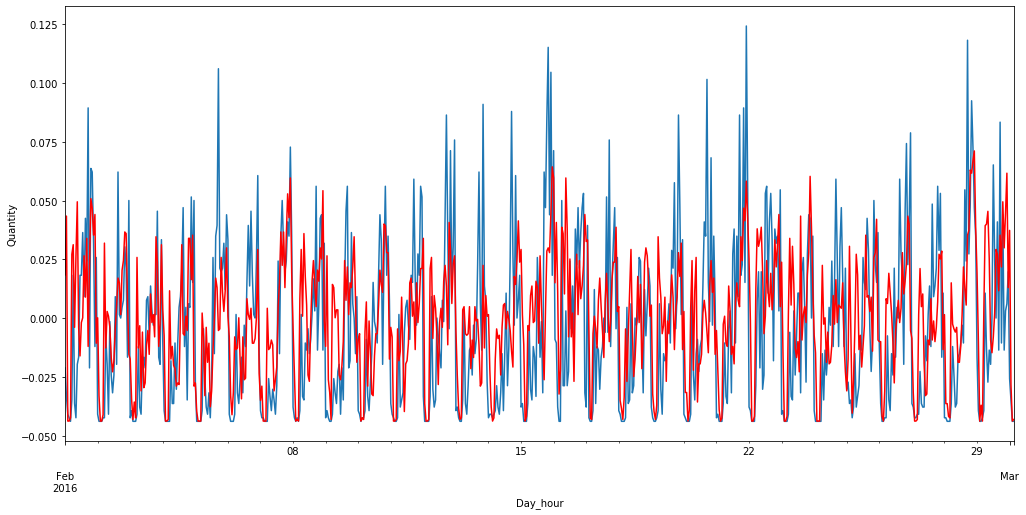

In [25]:
#Построим график для какого ни будь ряда. Например для 2119 и 2168.
plt.figure(figsize(17,8))
data_st['2119'][744:700+744].plot()
data_st['2168'][744:700+744].plot(color='r')
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

##### 3.Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

Попробую кластеризировать двумя разными методами MeanShift и KMeans.

Сначала MeanShift.

In [24]:
clustering_ms= MeanShift(bandwidth=8)#Создаем кластеризатор MeanShift

In [25]:
data_st_t=data_st.T #Повернем таблицу данных, так ее удобнее засовывать в кластеризатор

In [26]:
clustering_ms.fit_predict(data_st_t)#Обучаем кластеризатор и делаем кластеризацию

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 6, 0, 7, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [27]:
len(clustering_ms.cluster_centers_) #Проверяем число кластеров

8

In [28]:
regions['claster']=clustering_ms.labels_#Добавляем значение кластеров в таблицу данных зон

In [29]:
regions.head()#Проверяем

region       west       east      south      north       t_p_h        mean  \
0   1075 -74.022246 -74.011135  40.697437  40.705825   66.799731   59.669421   
1   1076 -74.022246 -74.011135  40.705825  40.714213  138.266129  129.564050   
2   1077 -74.022246 -74.011135  40.714213  40.722601   86.802419   82.852273   
3   1125 -74.011135 -74.000023  40.697437  40.705825   66.041667   65.987603   
4   1126 -74.011135 -74.000023  40.705825  40.714213  181.892473  179.808196   

      variance  claster  
0  1448.516240        0  
1  6560.196378        0  
2  3377.180718        0  
3  1651.565813        0  
4  9564.272189        0

In [30]:
regions['claster'].value_counts() #Посмотрим сколько зон в каждом кластере

0    95
7     1
6     1
5     1
4     1
3     1
2     1
1     1
Name: claster, dtype: int64

Кластеризация методом Kmeans.

In [31]:
clustering_km=KMeans(n_clusters=8, random_state=1)# Создаем кластеризатор

In [32]:
clustering_km.fit_predict(data_st_t)#Обучаем кластеризатор

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 4, 4, 3, 0, 4, 4, 0, 0, 4, 4, 7, 4, 1, 2, 1,
       1, 2, 2, 1, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
regions['claster_km']=clustering_km.labels_ #Добавляем кластеры в таблицу данных зон

In [34]:
regions.head()#Проверяем

region       west       east      south      north       t_p_h        mean  \
0   1075 -74.022246 -74.011135  40.697437  40.705825   66.799731   59.669421   
1   1076 -74.022246 -74.011135  40.705825  40.714213  138.266129  129.564050   
2   1077 -74.022246 -74.011135  40.714213  40.722601   86.802419   82.852273   
3   1125 -74.011135 -74.000023  40.697437  40.705825   66.041667   65.987603   
4   1126 -74.011135 -74.000023  40.705825  40.714213  181.892473  179.808196   

      variance  claster  claster_km  
0  1448.516240        0           0  
1  6560.196378        0           0  
2  3377.180718        0           0  
3  1651.565813        0           0  
4  9564.272189        0           0

In [35]:
regions['claster_km'].value_counts()#Смотрим сколько зон в каждом кластере.

0    71
3    11
4    10
1     4
2     3
7     1
6     1
5     1
Name: claster_km, dtype: int64

Попробую визуализировать кластеризацию и посмотреть какой метод сработал интереснее. Для этого посчитаю средние поездки за февраль и за март для каждой зоны и построю эти точки на скайтере.

In [36]:
#Добавляем столбцы со средними показателями поездок за февраль и март в таблицу регионов.
regions['feb_mean']=np.array(data_st_t[data_st_t.columns[744:750+672]].apply(np.mean, axis=1))
regions['mar_mean']=np.array(data_st_t[data_st_t.columns[750+672:750+672+744]].apply(np.mean, axis=1))

In [37]:
regions.head()#Проверяем

region       west       east      south      north       t_p_h        mean  \
0   1075 -74.022246 -74.011135  40.697437  40.705825   66.799731   59.669421   
1   1076 -74.022246 -74.011135  40.705825  40.714213  138.266129  129.564050   
2   1077 -74.022246 -74.011135  40.714213  40.722601   86.802419   82.852273   
3   1125 -74.011135 -74.000023  40.697437  40.705825   66.041667   65.987603   
4   1126 -74.011135 -74.000023  40.705825  40.714213  181.892473  179.808196   

      variance  claster  claster_km  feb_mean  mar_mean  
0  1448.516240        0           0 -0.001323  0.002817  
1  6560.196378        0           0 -0.000274  0.000878  
2  3377.180718        0           0 -0.000216  0.000137  
3  1651.565813        0           0  0.000702  0.002059  
4  9564.272189        0           0 -0.000155  0.000828

In [38]:
regions.tail()#Проверяем

region       west       east      south      north       t_p_h  \
97    2068 -73.800014 -73.788903  40.638719  40.647108   95.056452   
98    2069 -73.800014 -73.788903  40.647108  40.655496   10.545699   
99    2118 -73.788903 -73.777791  40.638719  40.647108  146.490591   
100   2119 -73.788903 -73.777791  40.647108  40.655496   34.692204   
101   2168 -73.777791 -73.766680  40.638719  40.647108   68.532258   

           mean     variance  claster  claster_km  feb_mean  mar_mean  
97    86.709366  3374.690563        0           0 -0.002085  0.000466  
98     9.566460    66.641810        0           0 -0.007903  0.010257  
99   132.162190  5728.386017        0           0 -0.001556  0.000876  
100   28.980028   659.598636        0           0 -0.004833  0.001343  
101   64.799242  1478.386482        0           0 -0.000889  0.001079

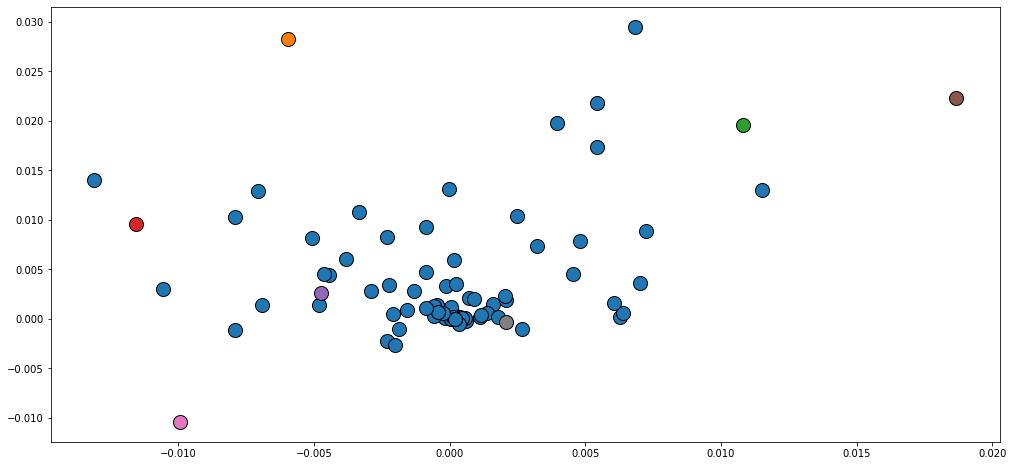

In [39]:
#Строим значения поездок февраль/март с цветами по кластерам для метода MeanShift
plt.figure(figsize(17,8))
for i in range(9):
    plt.plot(regions[regions.claster==i].feb_mean, regions[regions.claster==i].mar_mean, 'o', markeredgecolor='k', markersize=14)
pylab.show()

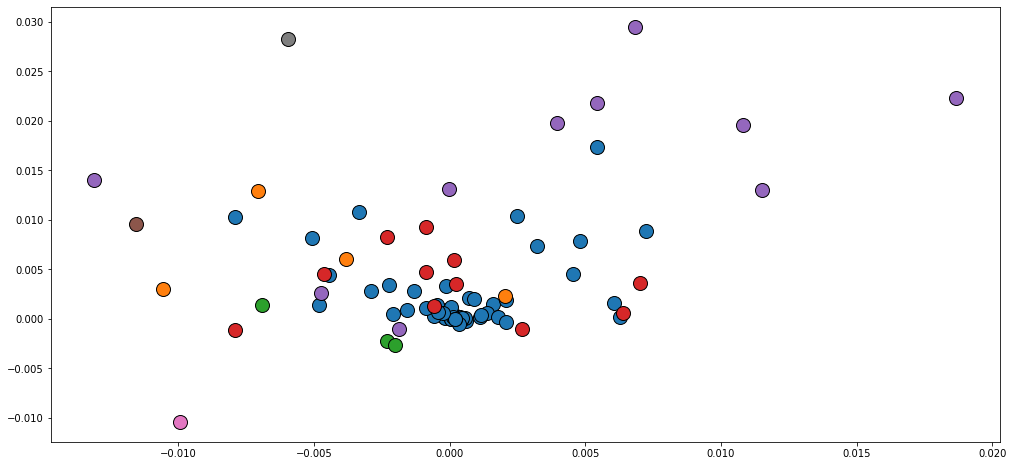

In [40]:
#Строим значения поездок февраль/март с цветами по кластерам для метода K-Means
plt.figure(figsize(17,8))
for i in range(8):
    plt.plot(regions[regions.claster_km==i].feb_mean, regions[regions.claster_km==i].mar_mean, 'o', markeredgecolor='k', markersize=14)
pylab.show()

В дальнейшем буду использовать результаты кластеризации методом Kmeans.

Нарисуем графики типичных зон кластеров.

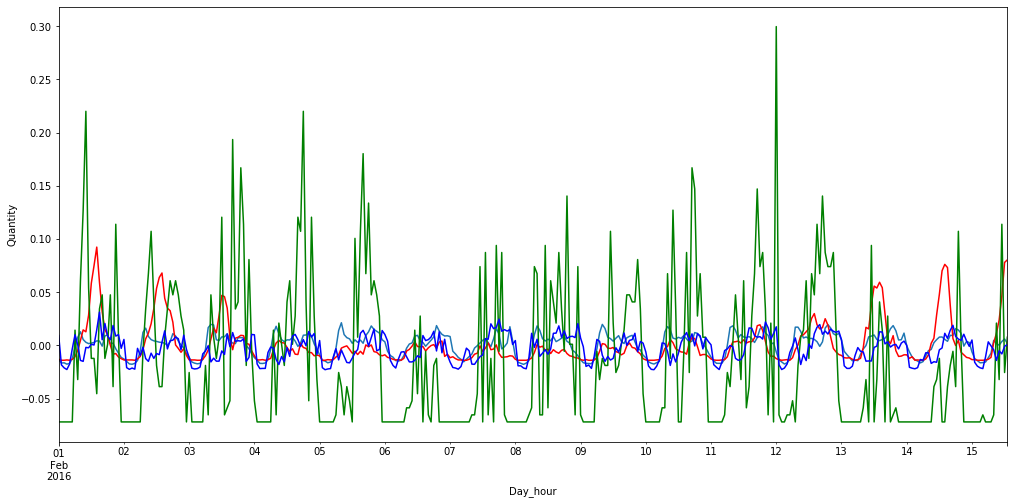

In [41]:
#Построим график для четырех рядов из кластера 0.
plt.figure(figsize(17,8))
data_st['1280'][744:350+744].plot()
data_st['1132'][744:350+744].plot(color='r')
data_st['1684'][744:350+744].plot(color='g')
data_st['2118'][744:350+744].plot(color='b')
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

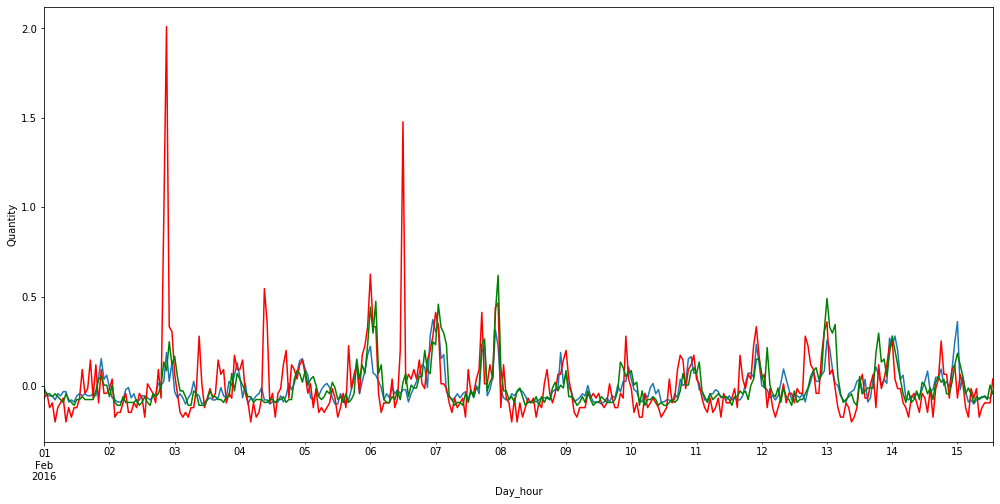

In [42]:
#Построим график для трех рядов из кластера 3.
plt.figure(figsize(17,8))
data_st['1222'][744:350+744].plot()
data_st['1380'][744:350+744].plot(color='r')
data_st['1378'][744:350+744].plot(color='g')
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

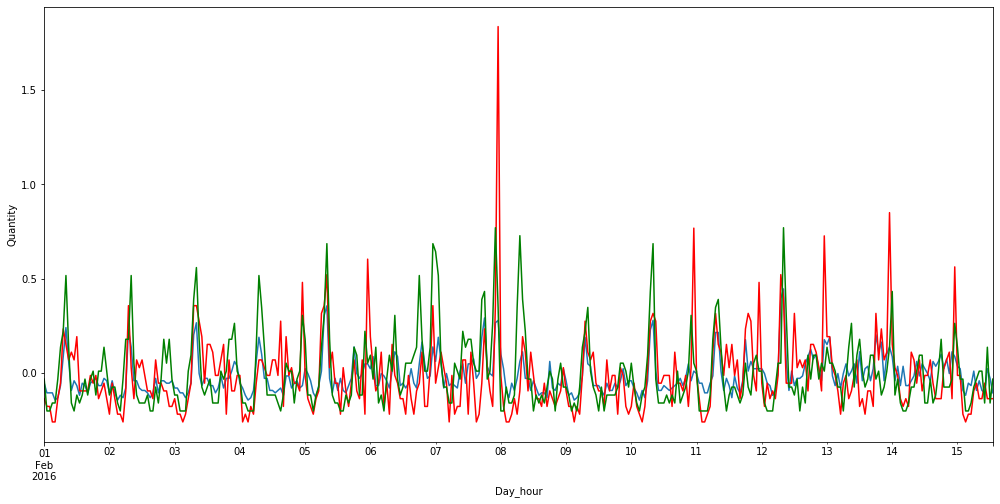

In [43]:
#Построим график для трех рядов из кластера 4.
plt.figure(figsize(17,8))
data_st['1390'][744:350+744].plot()
data_st['1442'][744:350+744].plot(color='r')
data_st['1172'][744:350+744].plot(color='g')
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

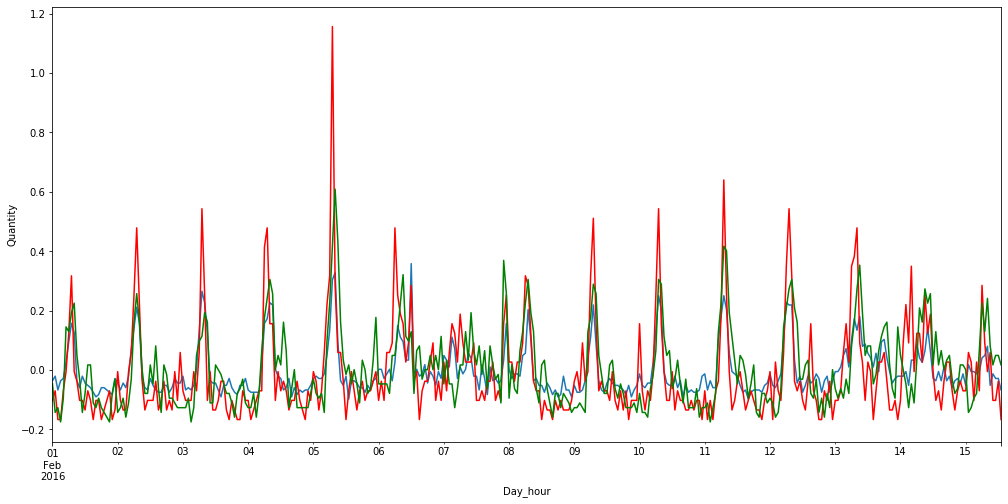

In [44]:
#Построим график для трех рядов из кластера 1.
plt.figure(figsize(17,8))
data_st['1530'][744:350+744].plot()
data_st['1580'][744:350+744].plot(color='r')
data_st['1483'][744:350+744].plot(color='g')
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

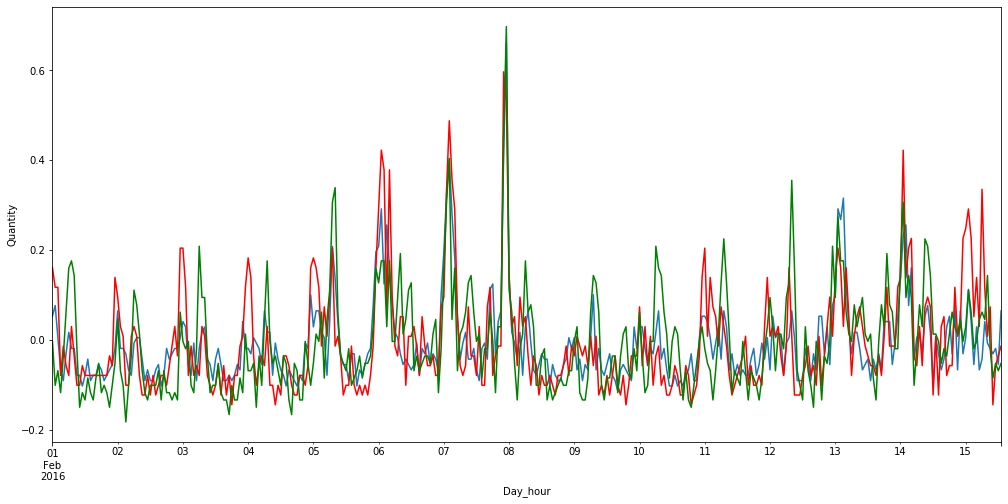

In [45]:
#Построим график для трех рядов из кластера 2.
plt.figure(figsize(17,8))
data_st['1533'][744:350+744].plot()
data_st['1532'][744:350+744].plot(color='r')
data_st['1482'][744:350+744].plot(color='g')
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

Остальные кластеры с одним элементом. Их рисовать не буду.

Судя по графикам, по форме то ряды в кластерах похожи.

##### 4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).

Определим зоны, ближайшие к центру кластеров. Потом будем их использовать для настройки SARIMAXов.

In [46]:
num_of_clast=len(regions['claster_km'].value_counts()) # определяем количество кластеров

In [47]:
#Создадим дата фрейм кластеров. Там соберем центры кластеров, номера зон, ближайших к центру.
clasters=pd.DataFrame(np.array(range(num_of_clast)), columns=['claster'])

In [48]:
clasters['center_zone']=np.zeros(num_of_clast)# Создадим столбец, где будем собирать номера центральных зон

In [49]:
regions['dist_to_centr']=np.zeros(regions.shape[0]) # Создадим в таблице зон столбец с расстоянием от зоны до центра кластера

In [50]:
#В цикле посчитаем расстояния от центра кластера для каждой зоны
for i in range(regions.shape[0]):
    regions['dist_to_centr'][i]=distance.euclidean(clustering_km.cluster_centers_[regions['claster_km'][i]], 
                                                   np.array(data_st_t.iloc[i]))

In [51]:
regions.tail(3)#Проверяем что получилось

region       west       east      south      north       t_p_h  \
99    2118 -73.788903 -73.777791  40.638719  40.647108  146.490591   
100   2119 -73.788903 -73.777791  40.647108  40.655496   34.692204   
101   2168 -73.777791 -73.766680  40.638719  40.647108   68.532258   

           mean     variance  claster  claster_km  feb_mean  mar_mean  \
99   132.162190  5728.386017        0           0 -0.001556  0.000876   
100   28.980028   659.598636        0           0 -0.004833  0.001343   
101   64.799242  1478.386482        0           0 -0.000889  0.001079   

     dist_to_centr  
99        0.752580  
100       1.836944  
101       1.238264

In [52]:
#В цикле найдем для каждого кластера номер зоны, ближайшей к центру кластера.
for i in range(clasters.shape[0]):
    clasters['center_zone'][i]=regions[regions['claster_km']==i].region.loc[regions[regions['claster_km']==i].dist_to_centr.idxmin()]

In [53]:
clasters['center_zone']=clasters['center_zone'].apply(int)

In [54]:
clasters #Смотрим что получилось.

claster  center_zone
0        0         1280
1        1         1530
2        2         1533
3        3         1222
4        4         1390
5        5         1225
6        6         1630
7        7         1441

##### 5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров \( p,d,q,P,D,Q \) — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!

Основываясь на опыте предыдущей недели буду делать генерацию синусов и косинусов 5й, 6й и 7й гармоник. Буду делать одно сезонное дифференцирование по суткам и два обычных дифференцирования.

Так как при расчете гармоник используются только данные о времени, то одни и теже регрессионные признаки можно использовать для рядов всех зон. Таким образом, создадим одну на всех таблицу регрессионных признаков. Делаем это для данных за шесть месяцев. Чтоб потом использовать при прогнозировании.

In [55]:
 #Создаем массив временных меток для ряда. Потом будем использовать его для расчета регрессионных признаков
time=[i + 1 for i in range(len(data))]

In [56]:
len(time)

4368

In [57]:
#Создаем дата фрейм, куда будем складывать регрессионные признаки.
exog_data=pd.DataFrame(time, columns=['T'], index=data.index)

In [58]:
#Заполняем таблицу признаков значениями.
exog_data['s5']=np.sin(exog_data['T']*2*3.14*(5+1)/168)
exog_data['s6']=np.sin(exog_data['T']*2*3.14*(6+1)/168)
exog_data['s7']=np.sin(exog_data['T']*2*3.14*(7+1)/168)
exog_data['c5']=np.cos(exog_data['T']*2*3.14*(5+1)/168)
exog_data['c6']=np.cos(exog_data['T']*2*3.14*(6+1)/168)
exog_data['c7']=np.cos(exog_data['T']*2*3.14*(7+1)/168)

In [59]:
exog_data.tail()#Проверяем

T        s5        s6        s7        c5        c6  \
Day_hour                                                                      
2016-06-30 19:00:00  4364 -0.984421 -0.998455 -0.958831  0.175827 -0.055568   
2016-06-30 20:00:00  4365 -0.920659 -0.978843 -0.999938  0.390368  0.204615   
2016-06-30 21:00:00  4366 -0.810778 -0.892591 -0.952286  0.585354  0.450868   
2016-06-30 22:00:00  4367 -0.660282 -0.745572 -0.820103  0.751018  0.666425   
2016-06-30 23:00:00  4368 -0.476710 -0.547795 -0.615125  0.879061  0.836613   

                           c7  
Day_hour                       
2016-06-30 19:00:00 -0.283976  
2016-06-30 20:00:00  0.011109  
2016-06-30 21:00:00  0.305208  
2016-06-30 22:00:00  0.572216  
2016-06-30 23:00:00  0.788430

Создадим массив датафреймов для центральных рядов кластеров. Делаем дифференцирования: одно сезонное и два обычных.

In [60]:
#Создадим дата-фреймы для данных для кластеров.
data_claster=[]
for zone in clasters.center_zone:
    data_claster.append(pd.DataFrame(data[str(zone)][:'2016-04-30 23:00:00']))

In [61]:
data_claster[0].tail()#Проверяем

1280
Day_hour                  
2016-04-30 19:00:00  332.0
2016-04-30 20:00:00  320.0
2016-04-30 21:00:00  303.0
2016-04-30 22:00:00  278.0
2016-04-30 23:00:00  281.0

In [62]:
#Делаем дифференцирования.
for i in range(len(data_claster)):
    #Сезонное, с периодом 24.
    data_claster[i]['sez']=data_claster[i][str(clasters.center_zone[i])]-data_claster[i][str(clasters.center_zone[i])].shift(24)
    #Обычное дифференцирование
    data_claster[i]['sez_diff']=data_claster[i]['sez']-data_claster[i]['sez'].shift(1)
    #Обычное дифференцирование
    data_claster[i]['sez_diff_diff']=data_claster[i]['sez_diff']-data_claster[i]['sez_diff'].shift(1)

In [63]:
data_claster[0].head(27)#Проверяем

1280    sez  sez_diff  sez_diff_diff
Day_hour                                                  
2016-01-01 00:00:00  272.0    NaN       NaN            NaN
2016-01-01 01:00:00  339.0    NaN       NaN            NaN
2016-01-01 02:00:00  307.0    NaN       NaN            NaN
2016-01-01 03:00:00  224.0    NaN       NaN            NaN
2016-01-01 04:00:00  123.0    NaN       NaN            NaN
2016-01-01 05:00:00   68.0    NaN       NaN            NaN
2016-01-01 06:00:00   57.0    NaN       NaN            NaN
2016-01-01 07:00:00   71.0    NaN       NaN            NaN
2016-01-01 08:00:00   86.0    NaN       NaN            NaN
2016-01-01 09:00:00   66.0    NaN       NaN            NaN
2016-01-01 10:00:00  120.0    NaN       NaN            NaN
2016-01-01 11:00:00  167.0    NaN       NaN            NaN
2016-01-01 12:00:00  171.0    NaN       NaN            NaN
2016-01-01 13:00:00  227.0    NaN       NaN            NaN
2016-01-01 14:00:00  170.0    NaN       NaN            NaN
2016-01-01 15:00:00  170.0    NaN       NaN            NaN
2016-01-01 16:00:00  171.0    NaN       NaN            NaN
2016-01-01 17:00:00  198.0    NaN       NaN            NaN
2016-01-01 18:00:00  215.0    NaN       NaN            NaN
2016-01-01 19:00:00  214.0    NaN       NaN            NaN
2016-01-01 20:00:00  202.0    NaN       NaN            NaN
2016-01-01 21:00:00  174.0    NaN       NaN            NaN
2016-01-01 22:00:00  163.0    NaN       NaN            NaN
2016-01-01 23:00:00  137.0    NaN       NaN            NaN
2016-01-02 00:00:00  197.0  -75.0       NaN            NaN
2016-01-02 01:00:00   83.0 -256.0    -181.0            NaN
2016-01-02 02:00:00   50.0 -257.0      -1.0          180.0

In [64]:
data_claster[0].tail()#Проверяем

1280   sez  sez_diff  sez_diff_diff
Day_hour                                                 
2016-04-30 19:00:00  332.0 -53.0      11.0           48.0
2016-04-30 20:00:00  320.0  17.0      70.0           59.0
2016-04-30 21:00:00  303.0  44.0      27.0          -43.0
2016-04-30 22:00:00  278.0  17.0     -27.0          -54.0
2016-04-30 23:00:00  281.0  52.0      35.0           62.0

Подбор структуры модели для кластера 0. Центральный ряд этого кластера - ряд зоны 1280.

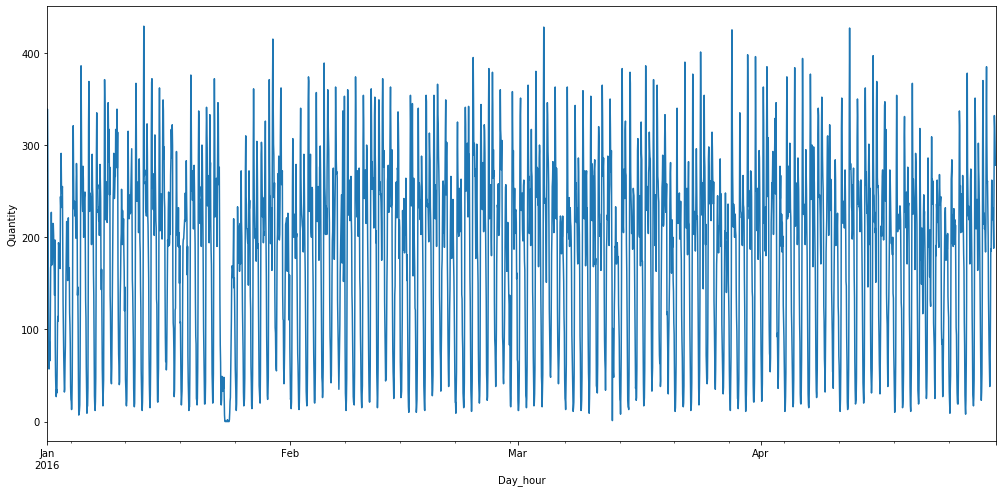

In [65]:
# Построим график нашего ряда.
plt.figure(figsize(17,8))
data_claster[0]['1280'].plot()
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

<Figure size 1080x1080 with 0 Axes>

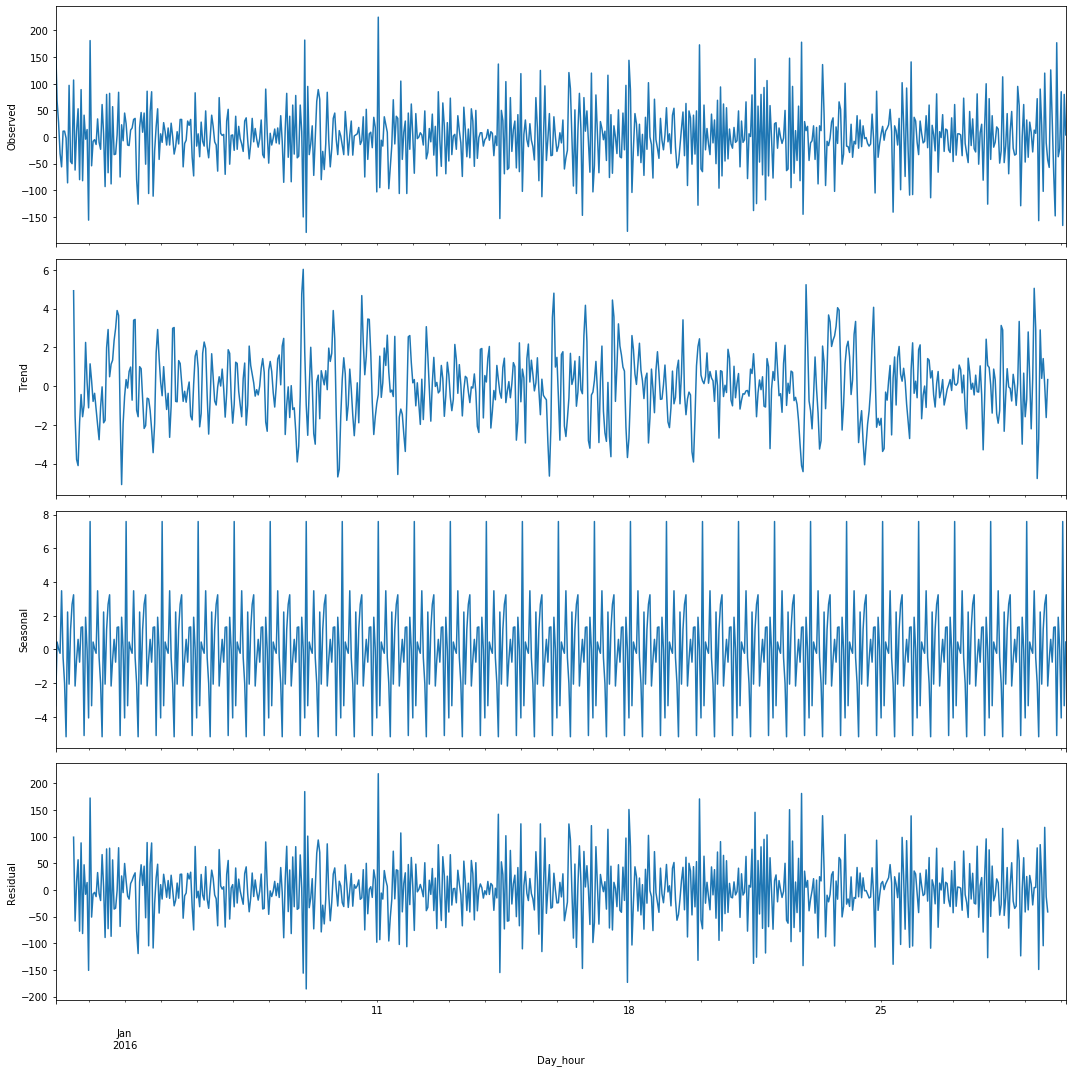

In [66]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data_claster[0]['sez_diff_diff'][26:700]).plot()
pylab.show()

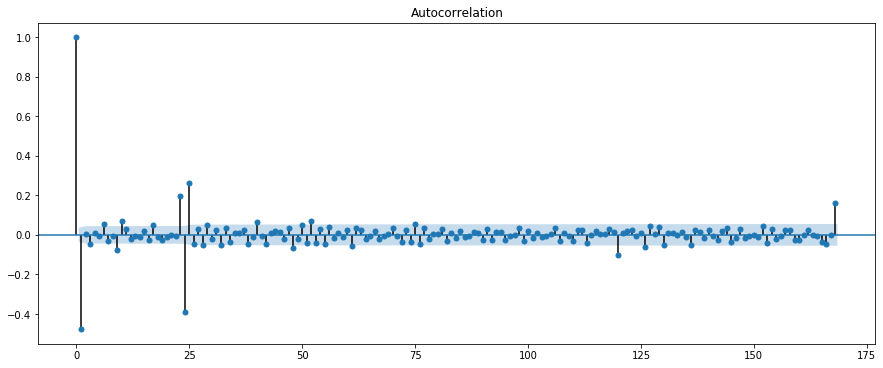

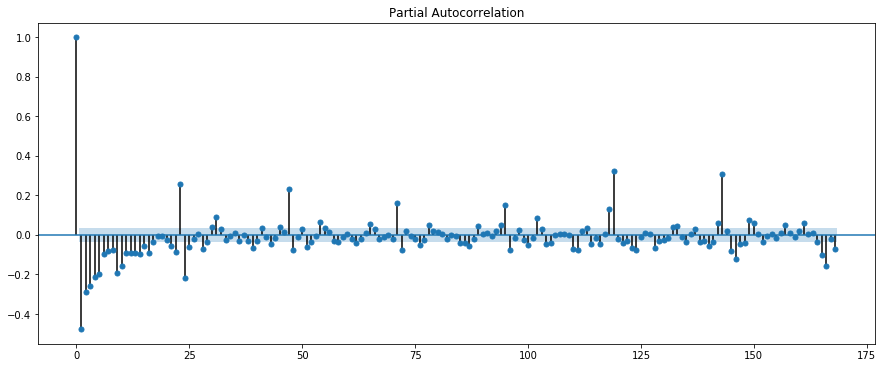

In [67]:
#Построим графики автокореляционной и частичной автокореляционной функций.
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_claster[0].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_claster[0].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

In [68]:
#Посчитаем критерий Дики-Фуллера для обработаного ряда.
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_claster[0].sez_diff_diff[26:])[1])

Критерий Дики-Фуллера: p=0.000000


Дики-Фуллер утверждает, что ряд стационарный.

В качестве первых приближений для подбора модели возьмем следующие значения: D=1, d=2, Q=1, q=1, P=1, p=2

Подбор структуры модели для кластера 1. Центральный ряд этого кластера - ряд зоны 1530.

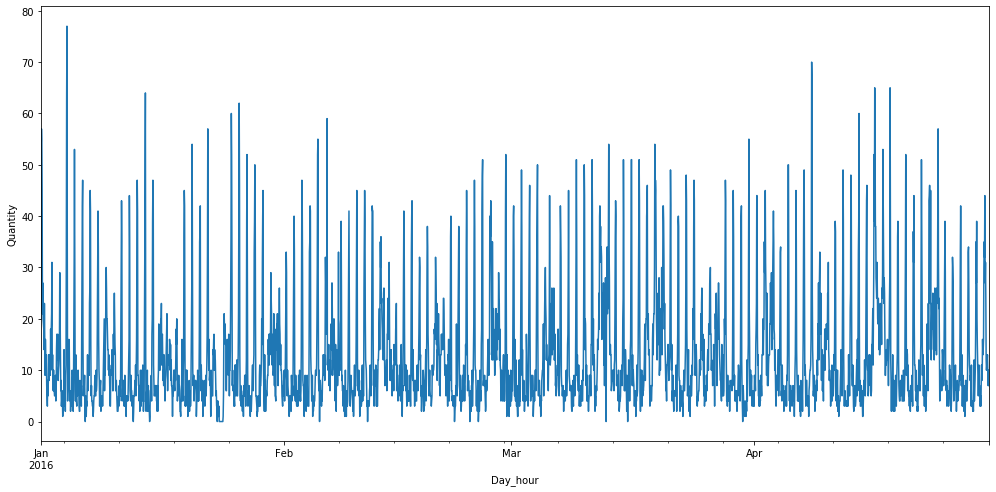

In [69]:
# Построим график нашего ряда.
plt.figure(figsize(17,8))
data_claster[1]['1530'].plot()
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

<Figure size 1080x1080 with 0 Axes>

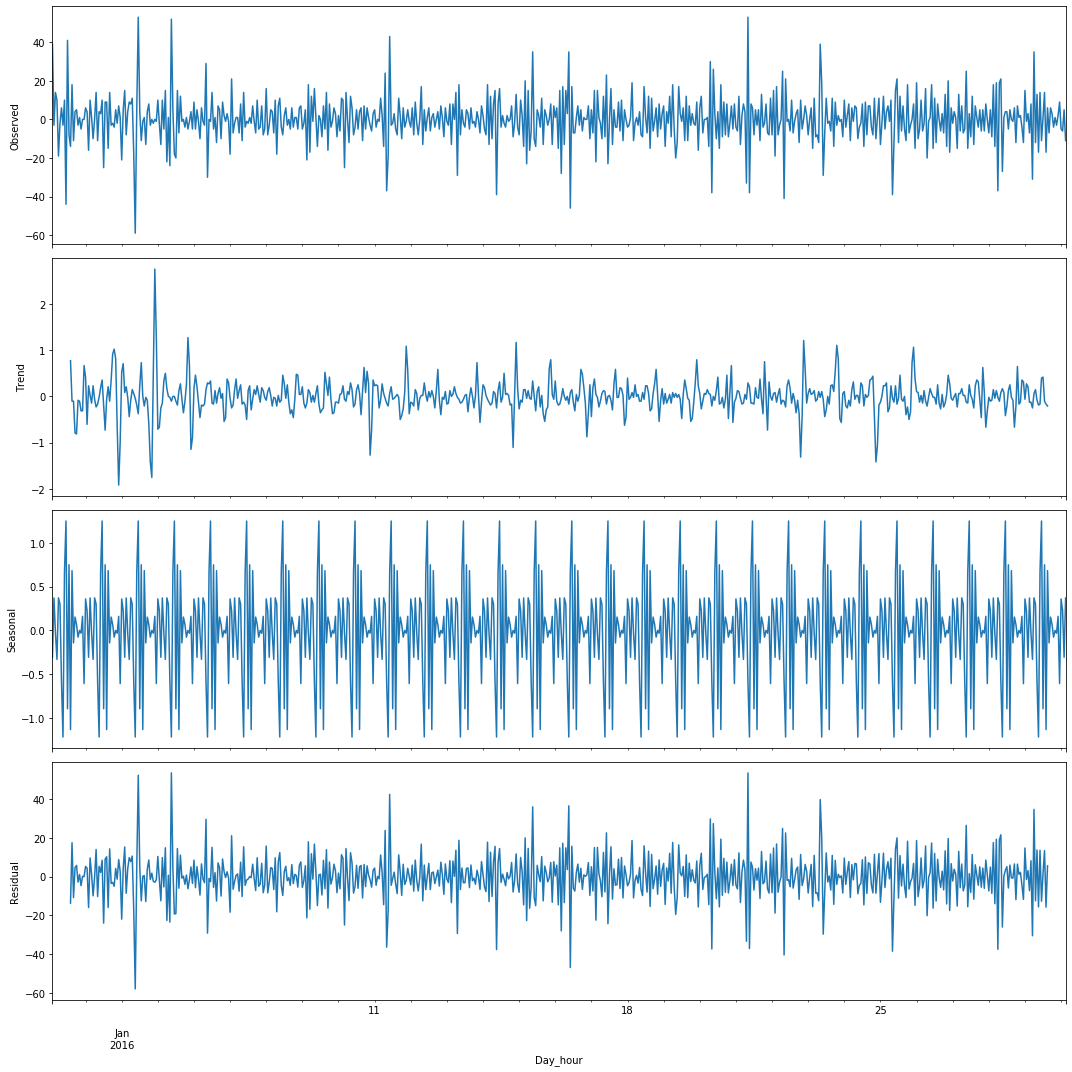

In [70]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data_claster[1]['sez_diff_diff'][26:700]).plot()
pylab.show()

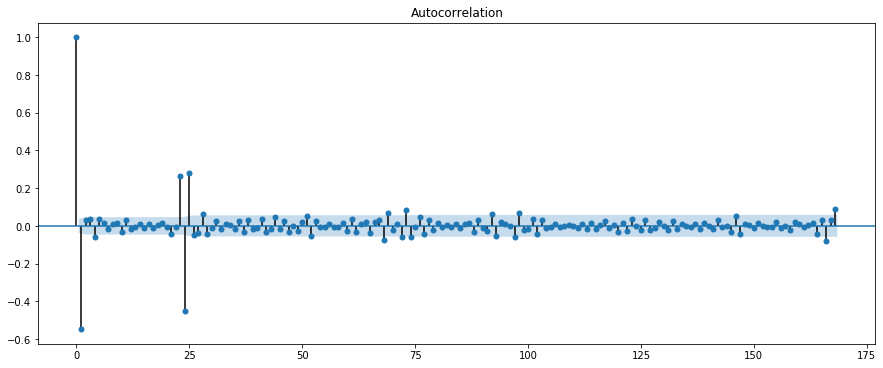

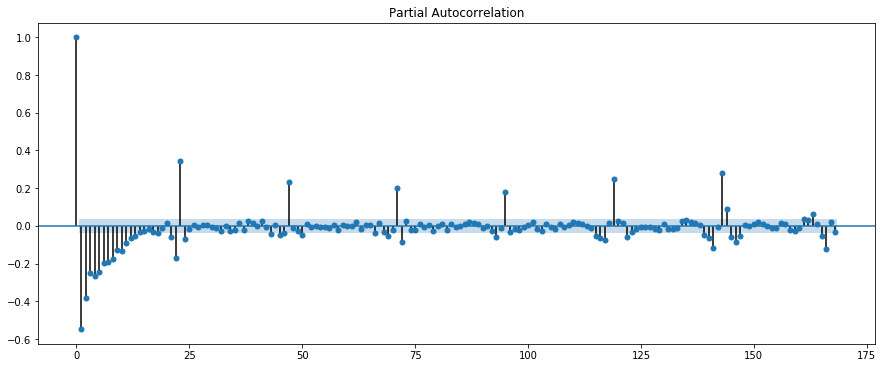

In [71]:
#Построим графики автокореляционной и частичной автокореляционной функций.
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_claster[1].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_claster[1].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

In [72]:
#Посчитаем критерий Дики-Фуллера для обработаного ряда.
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_claster[1].sez_diff_diff[26:])[1])

Критерий Дики-Фуллера: p=0.000000


Дики-Фуллер утверждает, что ряд стационарный.

В качестве первых приближений для подбора модели возьмем следующие значения: D=1, d=2, Q=1, q=1, P=1, p=2

Подбор структуры модели для кластера 2. Центральный ряд этого кластера - ряд зоны 1533.

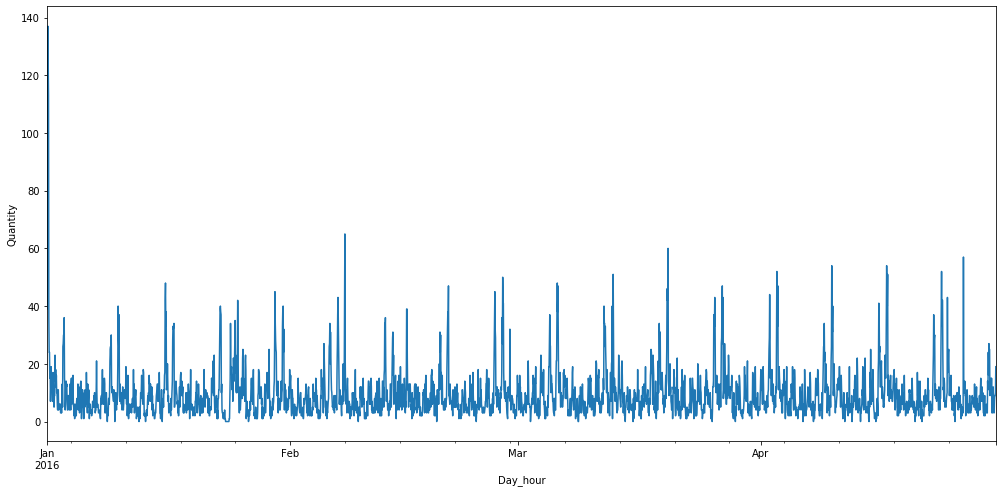

In [73]:
# Построим график нашего ряда.
plt.figure(figsize(17,8))
data_claster[2]['1533'].plot()
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

<Figure size 1080x1080 with 0 Axes>

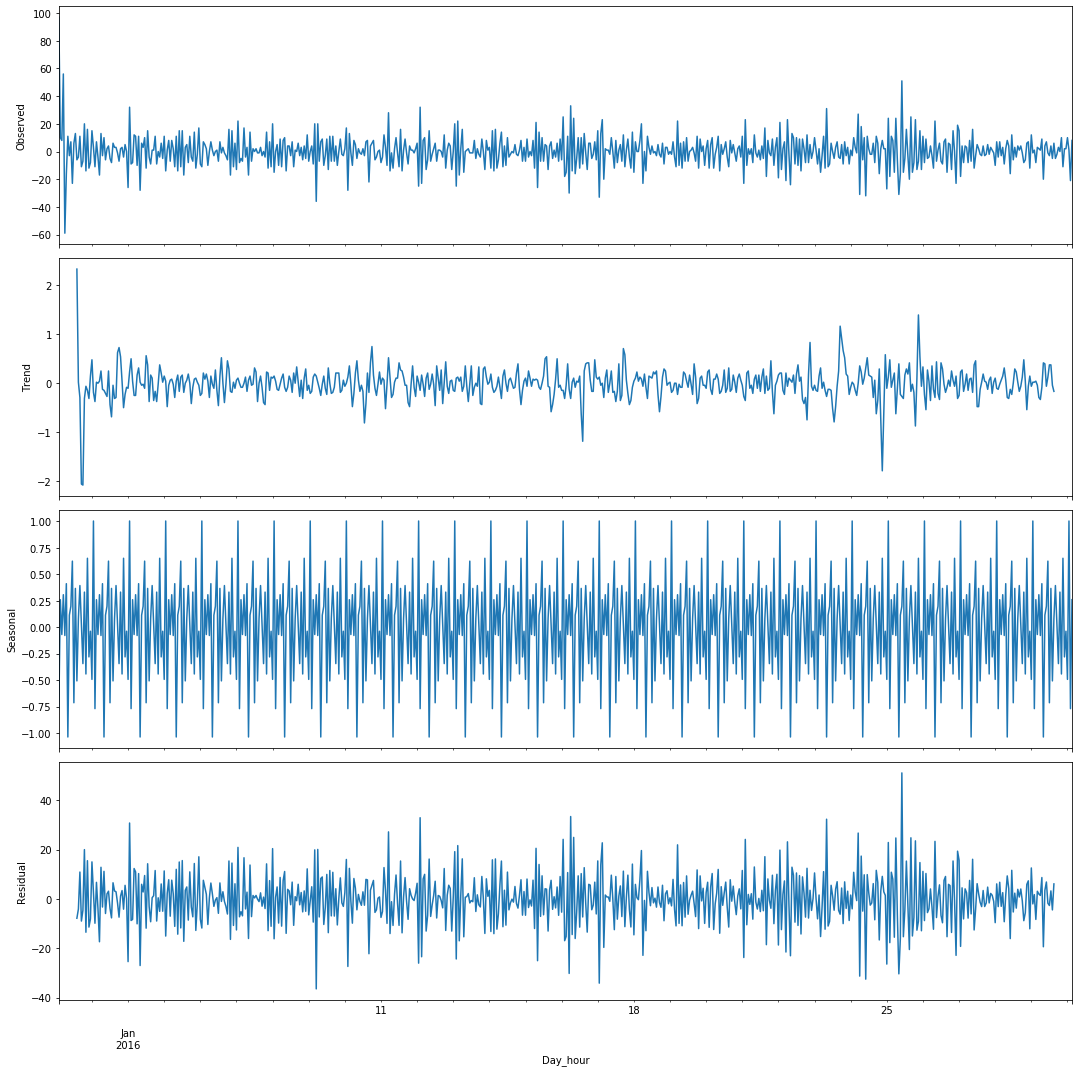

In [74]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data_claster[2]['sez_diff_diff'][26:700]).plot()
pylab.show()

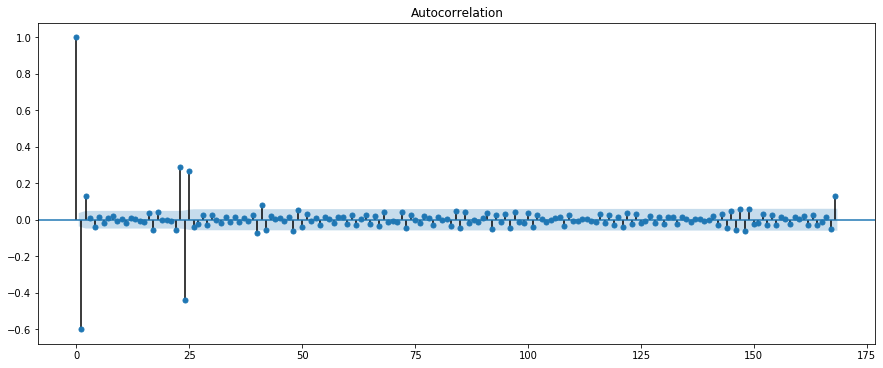

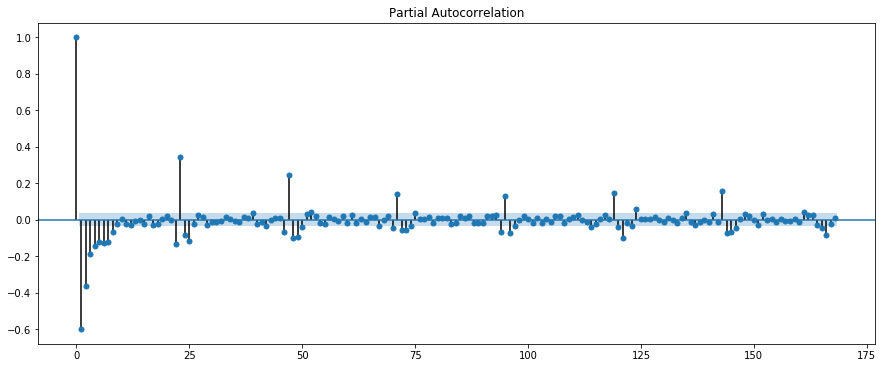

In [75]:
#Построим графики автокореляционной и частичной автокореляционной функций.
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_claster[2].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_claster[2].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

In [76]:
#Посчитаем критерий Дики-Фуллера для обработаного ряда.
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_claster[2].sez_diff_diff[26:])[1])

Критерий Дики-Фуллера: p=0.000000


Дики-Фуллер утверждает, что ряд стационарный.

В качестве первых приближений для подбора модели возьмем следующие значения: D=1, d=2, Q=1, q=2, P=1, p=2

Подбор структуры модели для кластера 3. Центральный ряд этого кластера - ряд зоны 1222.

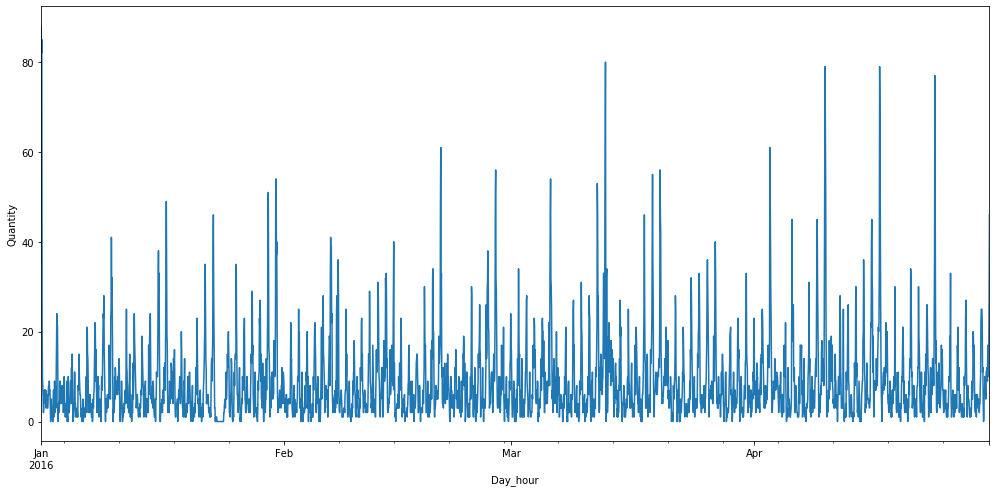

In [77]:
# Построим график нашего ряда.
plt.figure(figsize(17,8))
data_claster[3]['1222'].plot()
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

<Figure size 1080x1080 with 0 Axes>

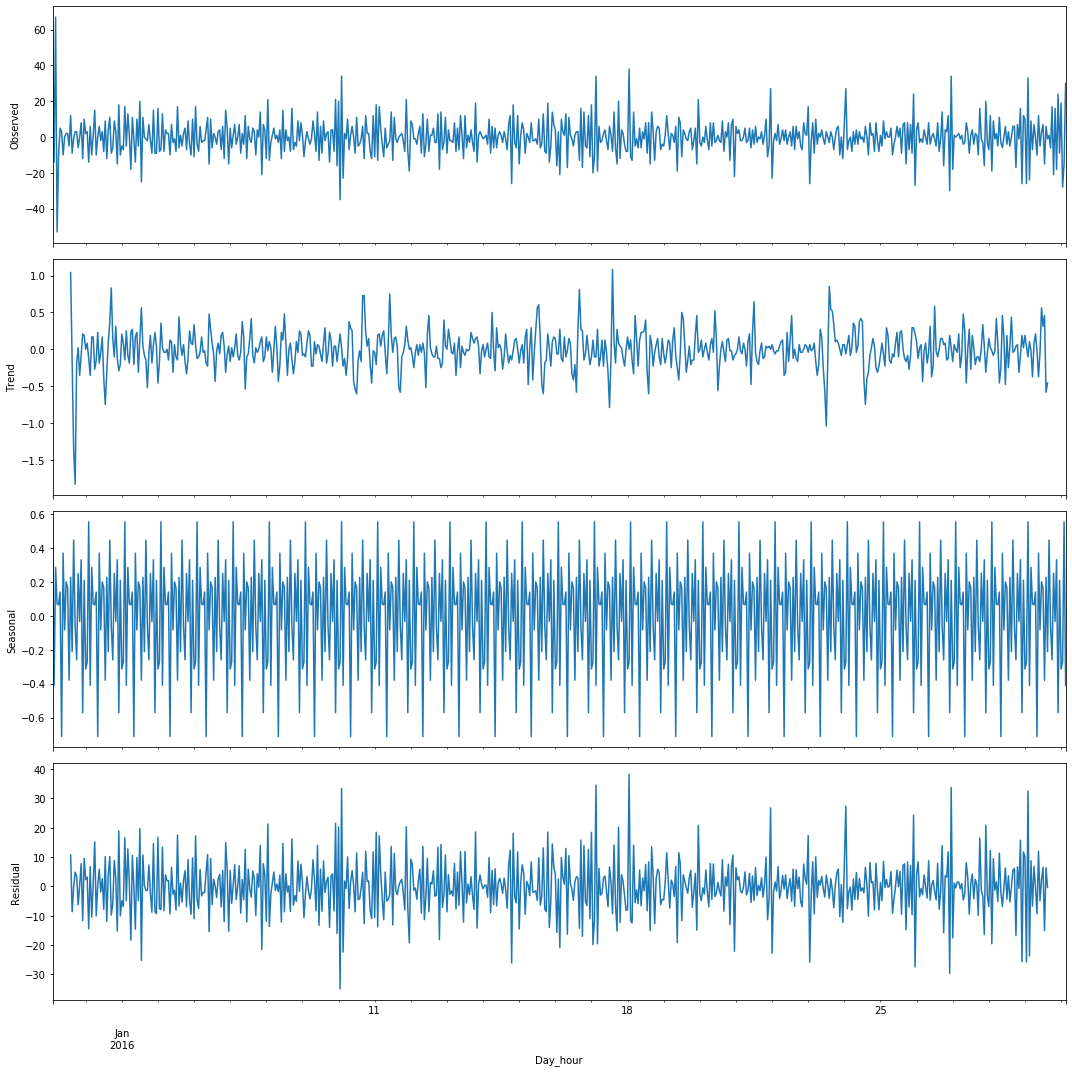

In [78]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data_claster[3]['sez_diff_diff'][26:700]).plot()
pylab.show()

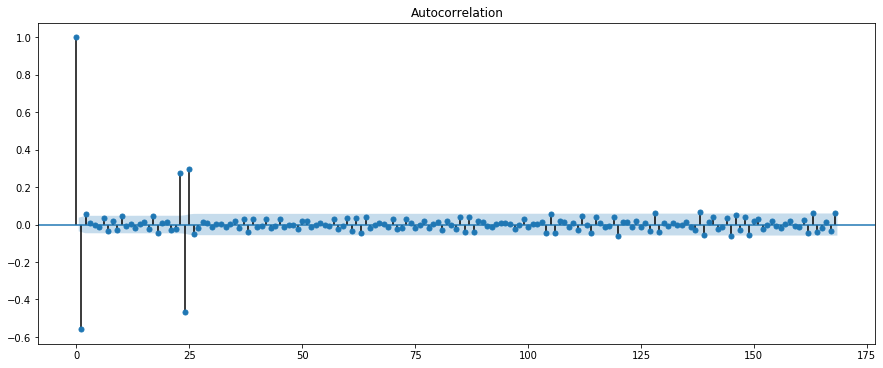

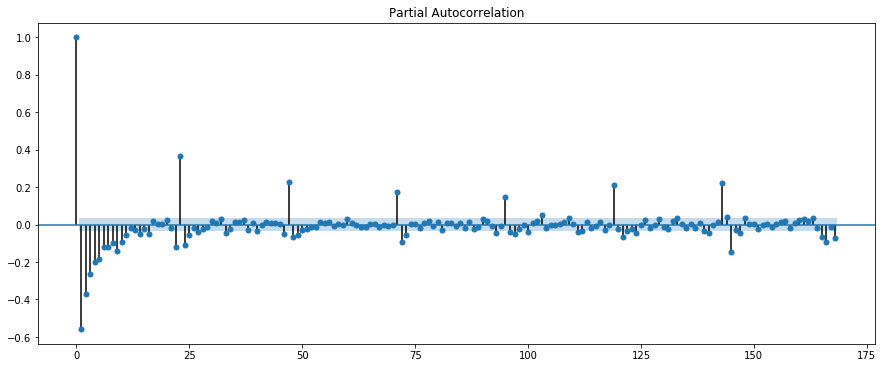

In [79]:
#Построим графики автокореляционной и частичной автокореляционной функций.
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_claster[3].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_claster[3].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

In [80]:
#Посчитаем критерий Дики-Фуллера для обработаного ряда.
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_claster[3].sez_diff_diff[26:])[1])

Критерий Дики-Фуллера: p=0.000000


Дики-Фуллер утверждает, что ряд стационарный.

В качестве первых приближений для подбора модели возьмем следующие значения: D=1, d=2, Q=1, q=1, P=1, p=2

Подбор структуры модели для кластера 4. Центральный ряд этого кластера - ряд зоны 1390.

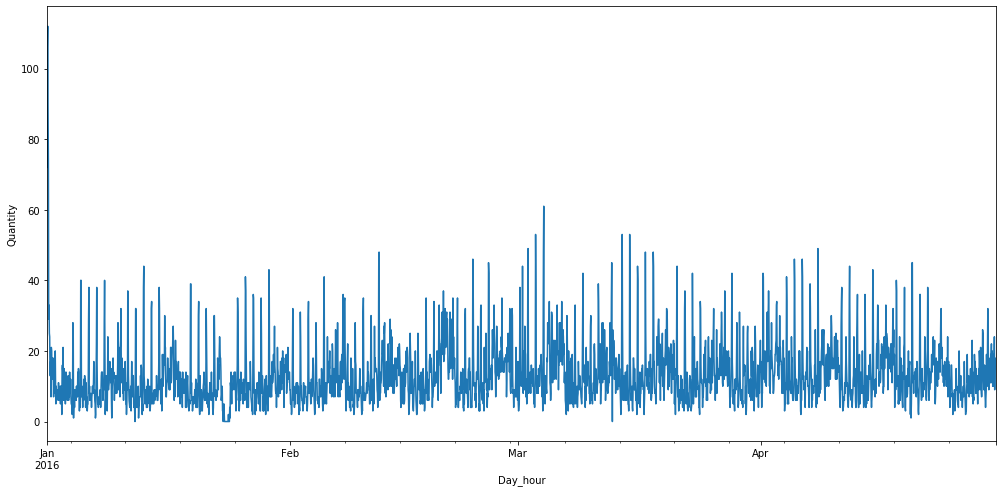

In [81]:
# Построим график нашего ряда.
plt.figure(figsize(17,8))
data_claster[4]['1390'].plot()
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

<Figure size 1080x1080 with 0 Axes>

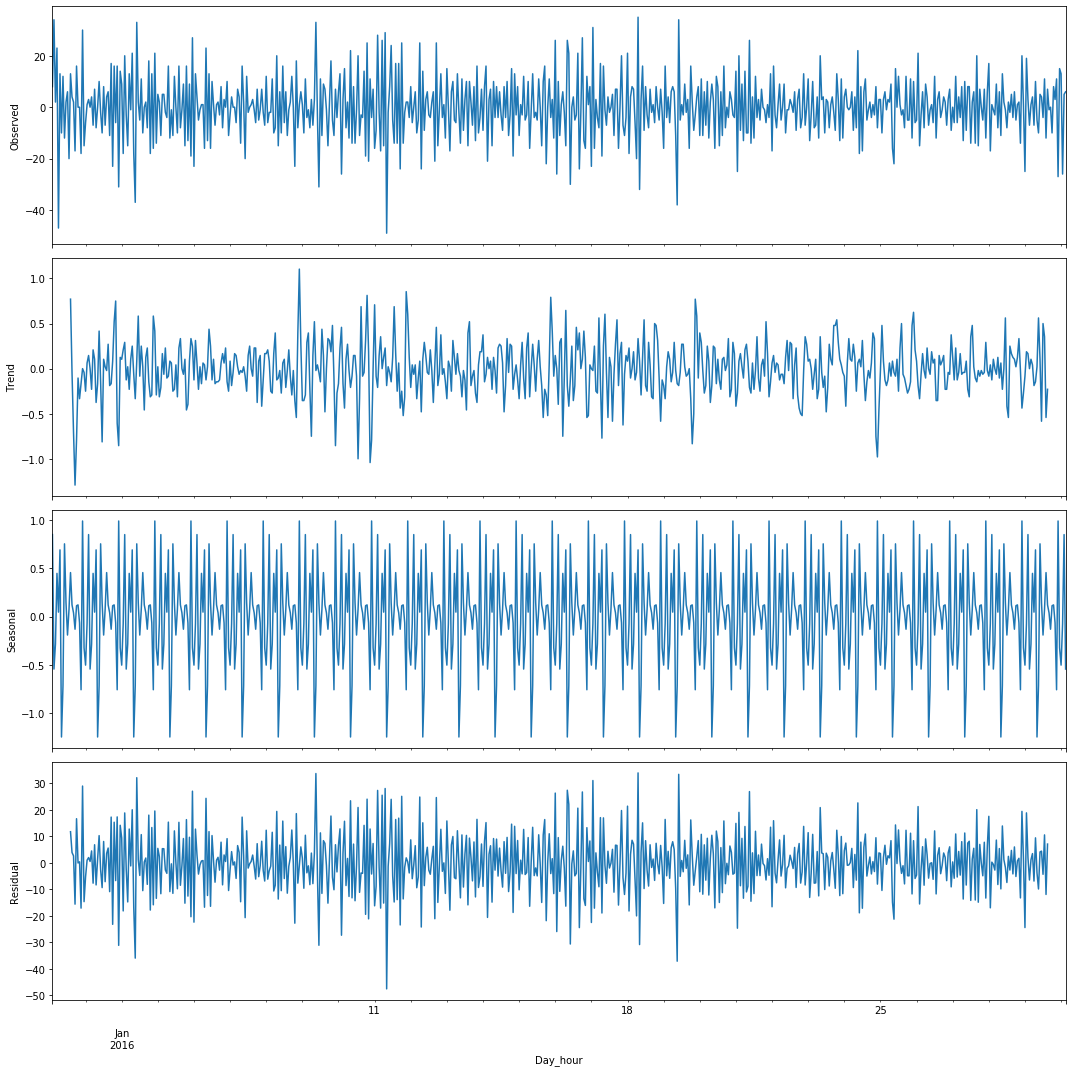

In [82]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data_claster[4]['sez_diff_diff'][26:700]).plot()
pylab.show()

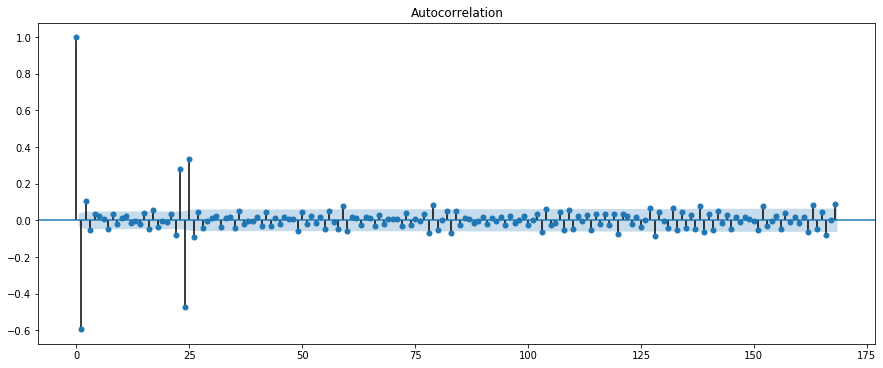

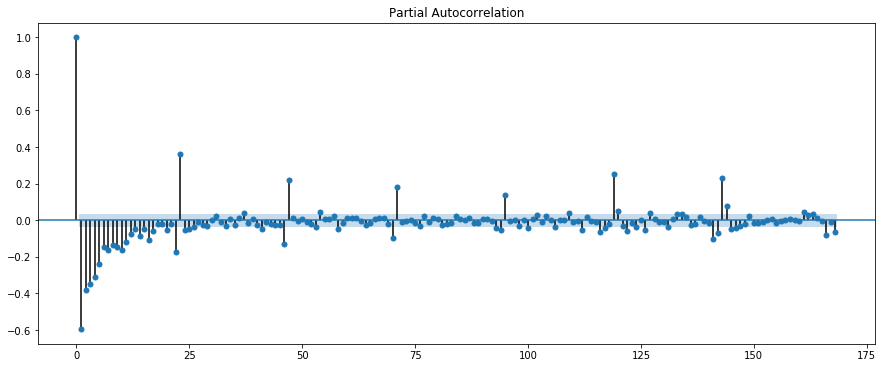

In [83]:
#Построим графики автокореляционной и частичной автокореляционной функций.
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_claster[4].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_claster[4].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

In [84]:
#Посчитаем критерий Дики-Фуллера для обработаного ряда.
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_claster[4].sez_diff_diff[26:])[1])

Критерий Дики-Фуллера: p=0.000000


Дики-Фуллер утверждает, что ряд стационарный.

В качестве первых приближений для подбора модели возьмем следующие значения: D=1, d=2, Q=1, q=2, P=1, p=2

Подбор структуры модели для кластера 5. Центральный ряд этого кластера - ряд зоны 1225.

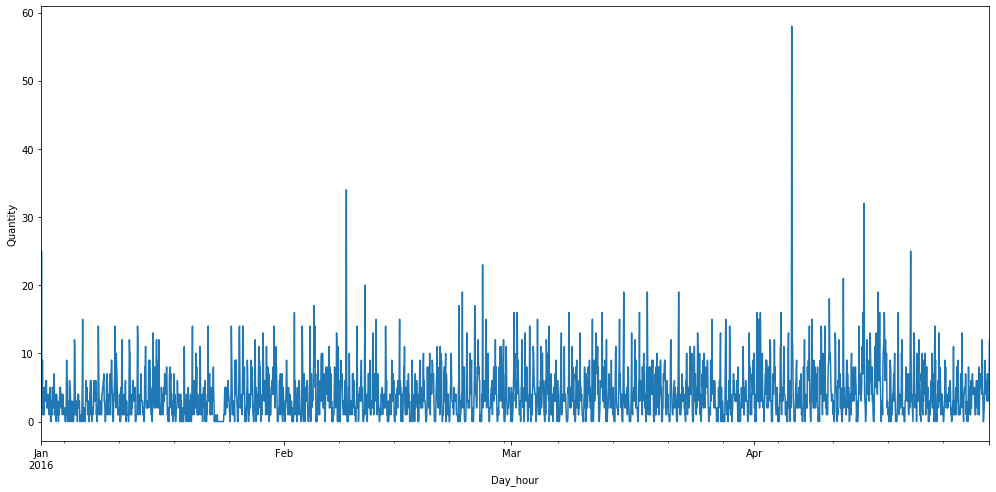

In [85]:
# Построим график нашего ряда.
plt.figure(figsize(17,8))
data_claster[5]['1225'].plot()
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

<Figure size 1080x1080 with 0 Axes>

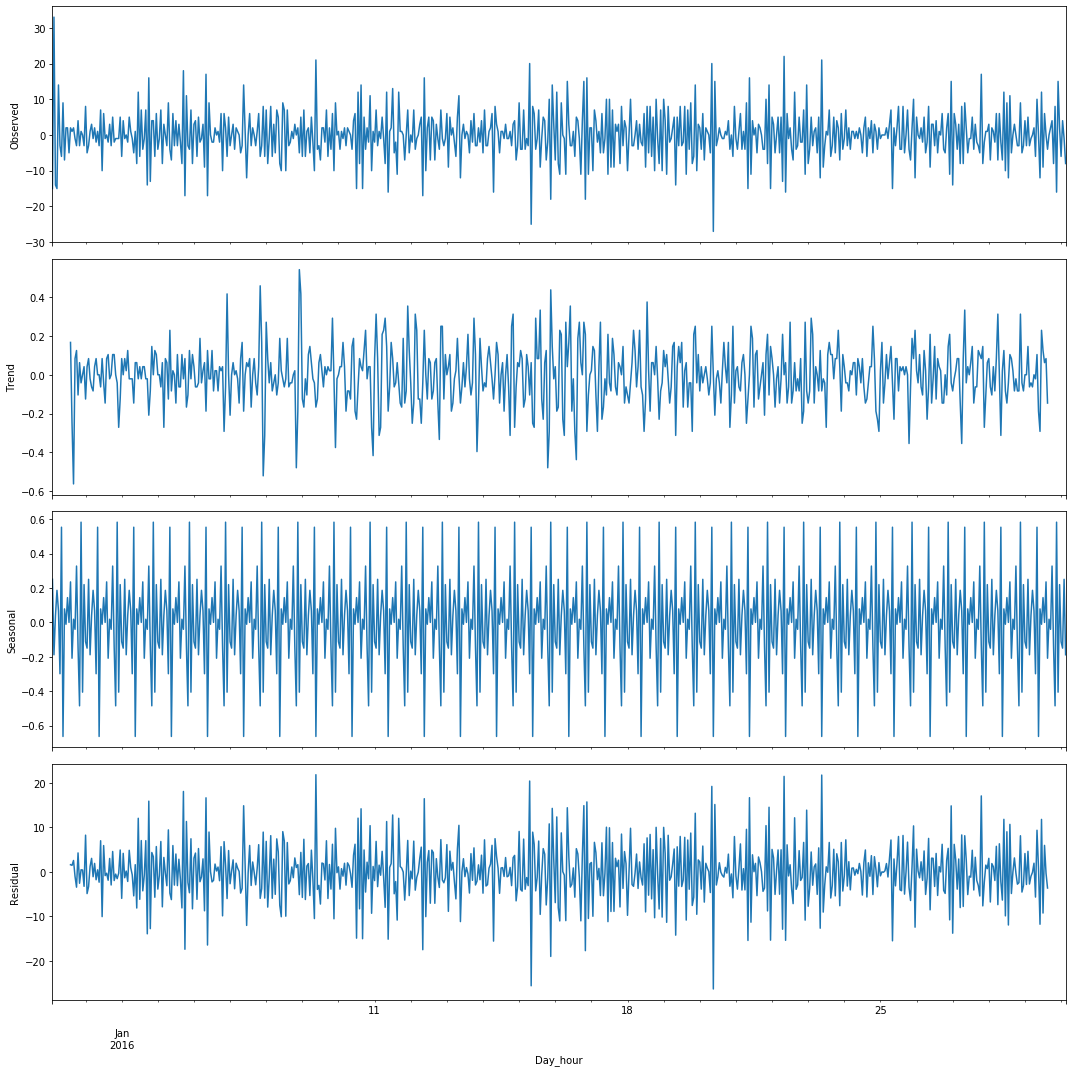

In [86]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data_claster[5]['sez_diff_diff'][26:700]).plot()
pylab.show()

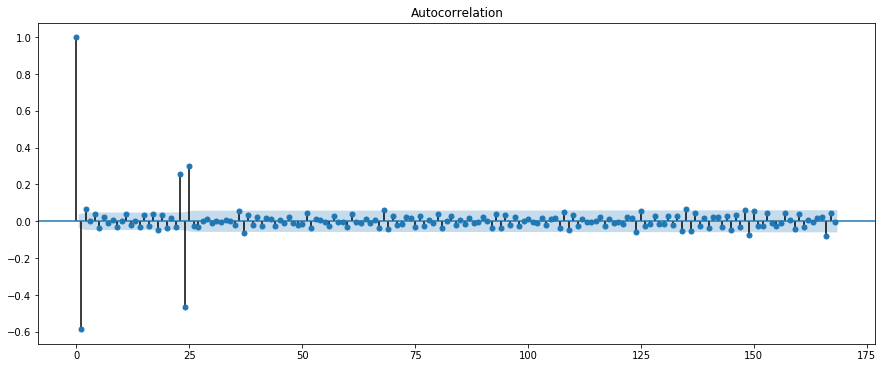

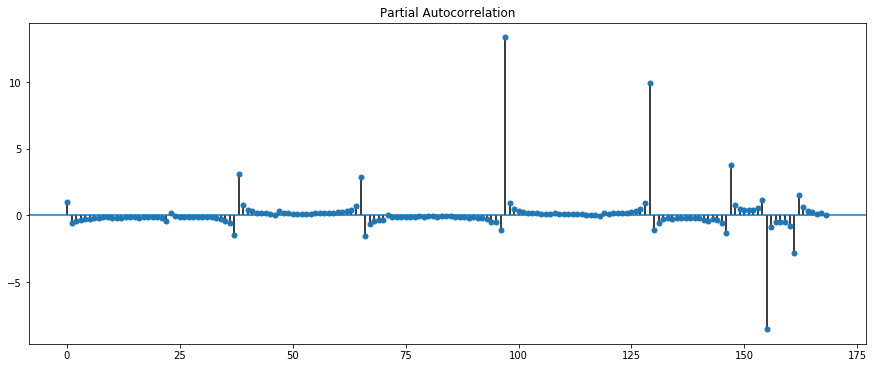

In [87]:
#Построим графики автокореляционной и частичной автокореляционной функций.
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_claster[5].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_claster[5].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

In [88]:
#Посчитаем критерий Дики-Фуллера для обработаного ряда.
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_claster[5].sez_diff_diff[26:])[1])

Критерий Дики-Фуллера: p=0.000000


Дики-Фуллер утверждает, что ряд стационарный.

В качестве первых приближений для подбора модели возьмем следующие значения: D=1, d=2, Q=1, q=2, P=0, p=1

Подбор структуры модели для кластера 6. Центральный ряд этого кластера - ряд зоны 1630.

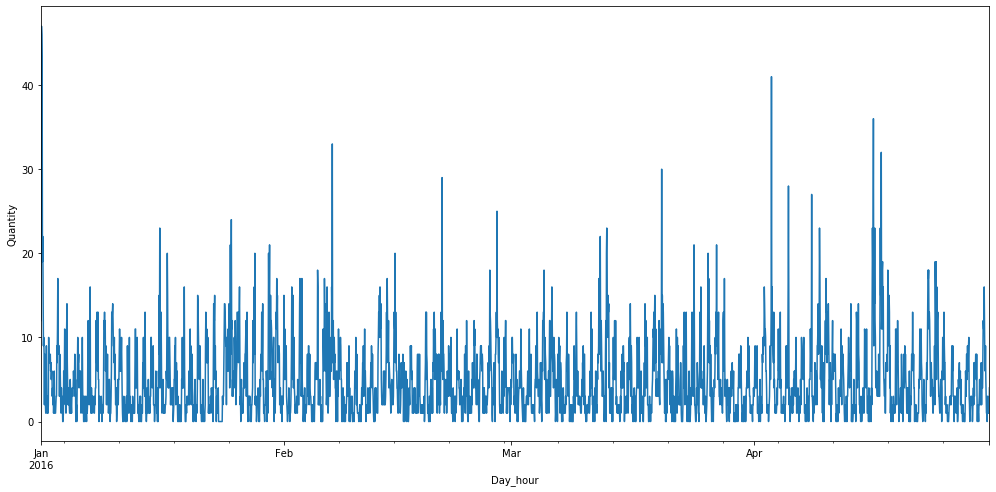

In [89]:
# Построим график нашего ряда.
plt.figure(figsize(17,8))
data_claster[6]['1630'].plot()
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

<Figure size 1080x1080 with 0 Axes>

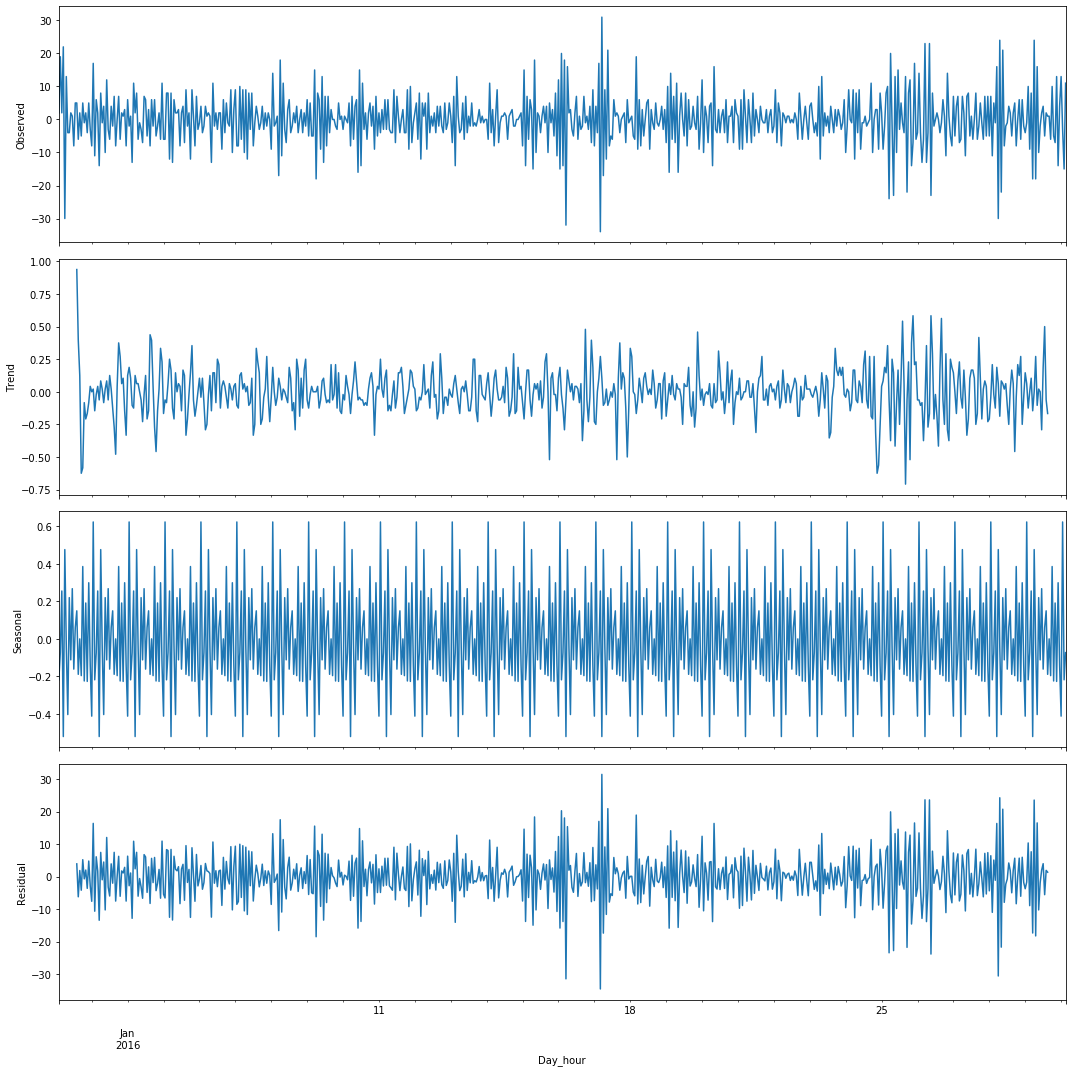

In [90]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data_claster[6]['sez_diff_diff'][26:700]).plot()
pylab.show()

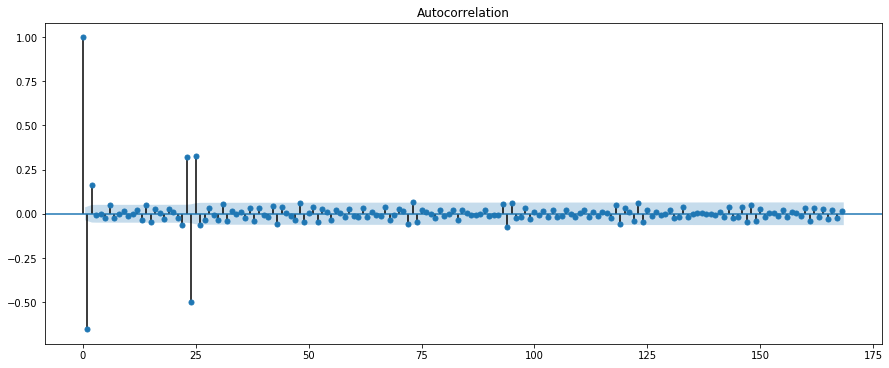

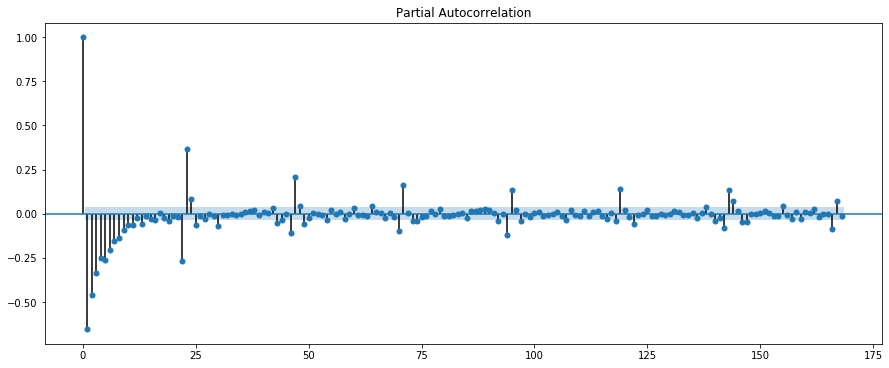

In [91]:
#Построим графики автокореляционной и частичной автокореляционной функций.
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_claster[6].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_claster[6].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

In [92]:
#Посчитаем критерий Дики-Фуллера для обработаного ряда.
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_claster[6].sez_diff_diff[26:])[1])

Критерий Дики-Фуллера: p=0.000000


Дики-Фуллер утверждает, что ряд стационарный.

В качестве первых приближений для подбора модели возьмем следующие значения: D=1, d=2, Q=1, q=2, P=2, p=2

Подбор структуры модели для кластера 7. Центральный ряд этого кластера - ряд зоны 1441.

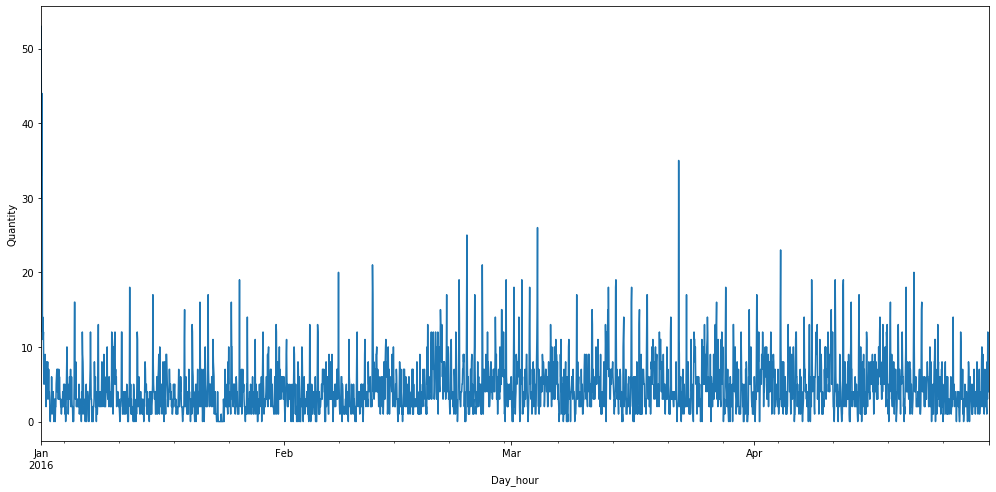

In [93]:
# Построим график нашего ряда.
plt.figure(figsize(17,8))
data_claster[7]['1441'].plot()
plt.xlabel('Day_hour')
plt.ylabel('Quantity')
pylab.show()

<Figure size 1080x1080 with 0 Axes>

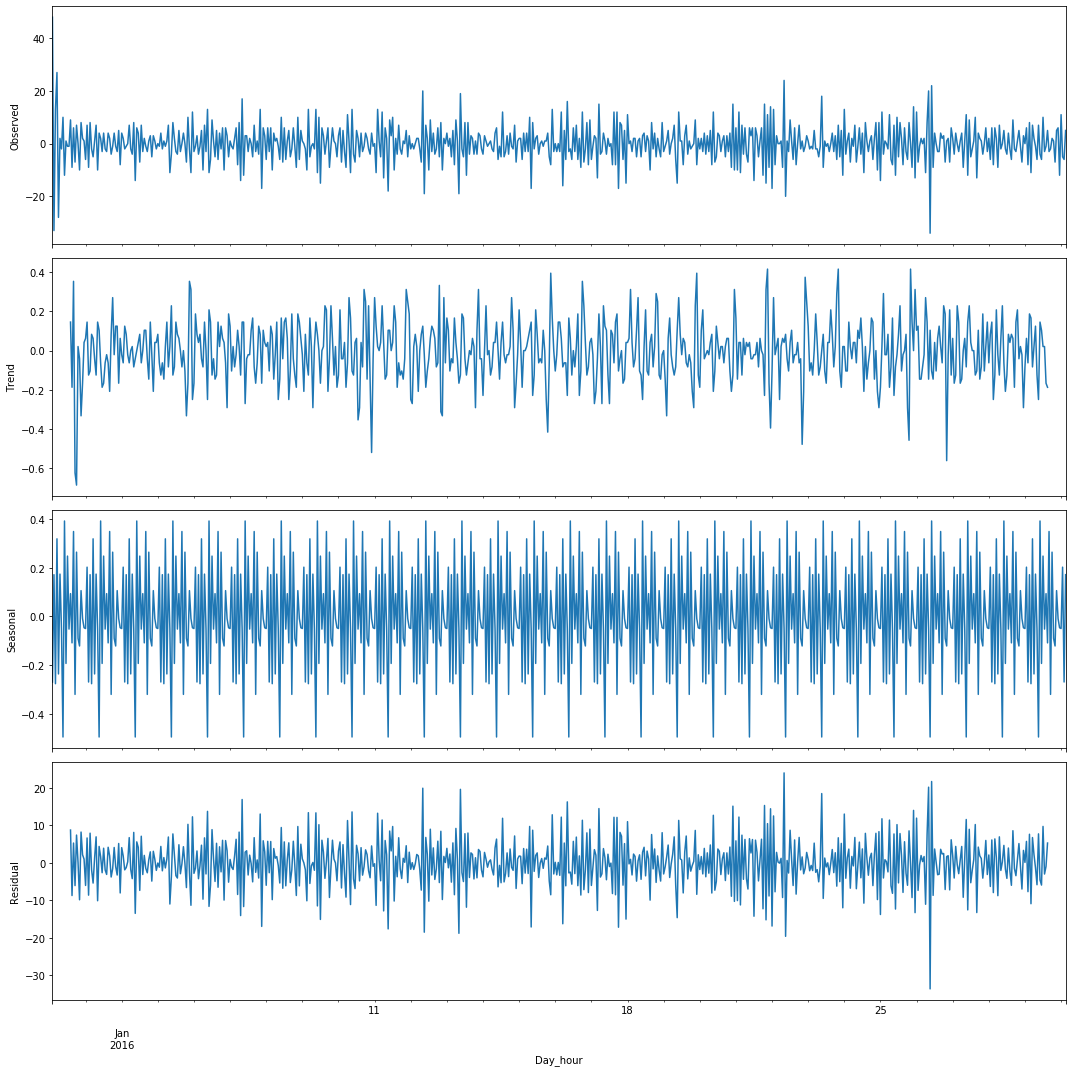

In [94]:
#Сделаем STL-декомпозицию.
plt.figure(figsize(15,15))
sm.tsa.seasonal_decompose(data_claster[7]['sez_diff_diff'][26:700]).plot()
pylab.show()

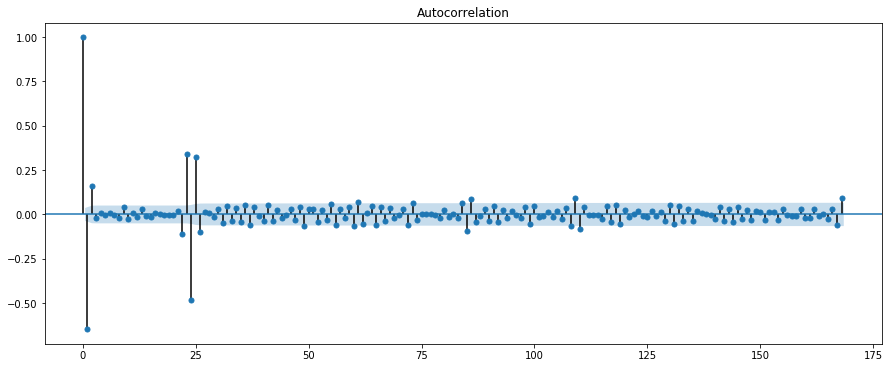

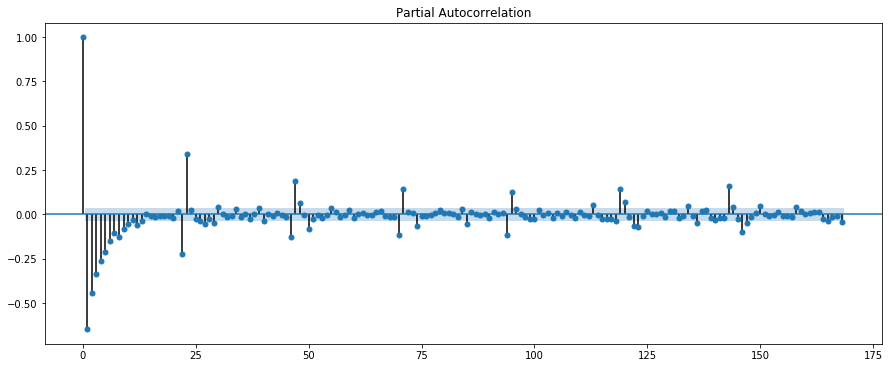

In [95]:
#Построим графики автокореляционной и частичной автокореляционной функций.
plt.figure(figsize(15,13))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_claster[7].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит автокреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_claster[7].sez_diff_diff[26:].values.squeeze(), lags=168, ax=ax)#Строит частичную автокореляцию
pylab.show()

In [96]:
#Посчитаем критерий Дики-Фуллера для обработаного ряда.
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_claster[7].sez_diff_diff[26:])[1])

Критерий Дики-Фуллера: p=0.000000


Дики-Фуллер утверждает, что ряд стационарный.

В качестве первых приближений для подбора модели возьмем следующие значения: D=1, d=2, Q=1, q=2, P=1, p=2

In [97]:
from itertools import product

Возможные гиперпараметры моделей лежат в интервале от 1 до 3 для p и q, и в интервале от 0 до 1 для P и Q. Поэтому создадим цикл с подбором оптимальных параметров для моделей для разных кластеров. Параметры будем перебирать из этих интервалов.

In [98]:
#Задаем интервалы, в которых будем перебирать значения параметров модели ARIMA
ps = range(1, 4)
d=2
qs = range(1, 4)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [99]:
#Создаем массив комбинаций параметров
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters) 
len(parameters_list)

36

In [100]:
exog_data1=exog_data.drop(columns=['T']) # Создадим дата фрейм с регрессионными признаками. Уберем значение времени.

Непосредственно сам цикл перебора (не советую запускать, считает более 5 часов):

In [106]:
%%time
models=[]# Создаем массив, куда будем складывать лучшие модели.
results_table=[]#Создаем массив, куда будем складывать перебираемые параметры и и АИКи.
model_params=[]#Создаем массив, куда будем складывать параметры лучших моделей для каждого кластера.
model_hyparams=[]#Создаем массив, куда будем складывать гиперпараметры лучших моделей для каждого кластера
warnings.filterwarnings('ignore')
for claster in clasters.claster: #Перебираем кластеры
    results = []
    best_aic = float("inf")
    for param in parameters_list:#Перебираем гиперпараметры
        try:
            model=sm.tsa.statespace.SARIMAX(data_claster[claster][str(clasters.center_zone[claster])], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24),
                                        exog=exog_data1[:'2016-04-30 23:00:00']).fit(disp=-1, maxiter=20)
    
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
    #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    #Добавляем модель, параметры и гиперпараметры в массивы
    models.append(best_model)
    results_table.append(results)
    model_params.append(best_model.params)
    model_hyparams.append(best_param)
warnings.filterwarnings('default')

Wall time: 5h 18min 46s


In [108]:
for claster in clasters.claster:
    print(models[claster].summary()) #Печатаем обзоры моделей для кластеров

                                 Statespace Model Results                                 
Dep. Variable:                               1280   No. Observations:                 2904
Model:             SARIMAX(3, 2, 2)x(1, 1, 1, 24)   Log Likelihood              -14160.495
Date:                            Wed, 04 Sep 2019   AIC                          28348.990
Time:                                    19:43:34   BIC                          28432.498
Sample:                                01-01-2016   HQIC                         28379.091
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s5           -23.8732      4.424     -5.397      0.000     -32.543     -15.203
s6           812.0121    170.021   

In [116]:
model_params[0] #Посмотрим например параметры лучшей модели для кластера 0.

s5           -23.873219
s6           812.012103
s7            16.801215
c5            -3.341740
c6          -181.315093
c7            20.705566
ar.L1         -0.896390
ar.L2         -0.025651
ar.L3         -0.062837
ma.L1         -0.053027
ma.L2         -0.945803
ar.S.L24       0.191469
ma.S.L24      -0.929475
sigma2      1086.210954
dtype: float64

Определение лучших моделей занимает много времени. Чтобы не заниматься этим всякий раз после остановки компа, создам датафрейм с параметрами моделей и запишу его в файл.

In [127]:
df_models_params=pd.DataFrame(model_params[0], columns=[0])#Датафрейм для параметров модели для кластера 0.

In [144]:
#В цикле добавим параметры моделей по остальным кластерам
for claster in clasters.claster.loc[1:]:
    df_models_params[claster]=model_params[claster]

In [145]:
df_models_params #Проверяем

0           1           2           3           4  \
s5         -23.873219    1.335299   -0.698216   -0.888320   -0.408380   
s6         812.012103  147.027802  390.266904  243.934851  102.531572   
s7          16.801215    0.497959    2.682740    1.499335    1.357376   
c5          -3.341740   -1.004337    1.597347    1.256417   -0.494697   
c6        -181.315093  -39.110372 -118.265911  -34.578182  -56.121158   
c7          20.705566    0.889893   -1.021452    0.801011    1.388262   
ar.L1       -0.896390   -0.213231   -0.970536   -0.192210   -0.466343   
ar.L2       -0.025651   -0.170934         NaN   -0.116267    0.503958   
ar.L3       -0.062837   -0.140753         NaN   -0.120393         NaN   
ma.L1       -0.053027   -0.992249   -0.253552   -0.995365   -0.926895   
ma.L2       -0.945803         NaN   -0.972064         NaN   -0.988234   
ar.S.L24     0.191469    0.119662    0.058087    0.084060         NaN   
ma.S.L24    -0.929475   -0.904587   -0.810951   -0.855755   -0.868851   
sigma2    1086.210954   41.025923   41.221222   35.173204   34.263059   

                  5           6          7  
s5        -0.167476    0.135507  -0.245607  
s6        12.990591  100.054645  92.172799  
s7        -0.082980    0.188357   0.665659  
c5         0.086976    0.663040  -0.073014  
c6        12.979981  -27.334221 -40.341914  
c7         0.536186   -0.638201   0.359620  
ar.L1     -0.511743   -0.678304  -0.610207  
ar.L2      0.484652    0.309921   0.381046  
ar.L3           NaN         NaN        NaN  
ma.L1     -0.977726   -0.906497  -0.944022  
ma.L2     -0.999481   -0.994967  -0.997551  
ar.S.L24        NaN         NaN        NaN  
ma.S.L24  -0.993378   -0.787502  -0.791279  
sigma2    10.578249   10.729578   9.741127

In [151]:
df_models_params.to_csv('models_params.csv',  index_label='Parametr')#Записываем в файл

Гиперпараметры моделей также запишем в таблицу и в файл.

In [154]:
model_hyparams#Гиперпараметры моделей

[(3, 2, 1, 1),
 (3, 1, 1, 1),
 (1, 3, 1, 1),
 (3, 1, 1, 1),
 (2, 3, 0, 1),
 (2, 3, 0, 1),
 (2, 3, 0, 1),
 (2, 3, 0, 1)]

In [161]:
df_model_hyparams=pd.DataFrame(model_hyparams, columns=['p','q','P','Q'])#Записываем в таблицу

In [163]:
df_model_hyparams.to_csv('models_hyparams.csv', index=False)#Записываем в файл

In [168]:
df_model_hyparams

p  q  P  Q
0  3  2  1  1
1  3  1  1  1
2  1  3  1  1
3  3  1  1  1
4  2  3  0  1
5  2  3  0  1
6  2  3  0  1
7  2  3  0  1

##### 6. Для каждой из \( R \) географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:

$$Q_{may} =\frac1{R* 739* 6} \sum\limits_{r=1}^{R} \sum_{T=2016.04.30\,23:00}^{2016.05.31\,17:00} \sum_{i=1}^6 \left| \hat{y}^r_{T|T+i} - y_{T+i}^r \right|$$

In [194]:
data.head(2)#Вспоминаем как выглядит таблица данных по поездкам

1075   1076  1077   1125   1126   1127   1128   1129  \
Day_hour                                                                    
2016-01-01 00:00:00  80.0  144.0  50.0   77.0  319.0  402.0  531.0  617.0   
2016-01-01 01:00:00  91.0  211.0  49.0  134.0  404.0  420.0  370.0  453.0   

                      1130   1131  ...  1630  1684  1733  1734  1783  2068  \
Day_hour                           ...                                       
2016-01-01 00:00:00  846.0  267.0  ...  12.0   0.0   2.0  44.0   5.0  41.0   
2016-01-01 01:00:00  594.0  224.0  ...  29.0   0.0   5.0   2.0   2.0   4.0   

                     2069  2118  2119  2168  
Day_hour                                     
2016-01-01 00:00:00   4.0  70.0   7.0  66.0  
2016-01-01 01:00:00   0.0  47.0   1.0  29.0  

[2 rows x 102 columns]

In [189]:
regions.head(2)#Вспоминаем как выглядит таблица данных по зонам

region       west       east      south      north       t_p_h        mean  \
0   1075 -74.022246 -74.011135  40.697437  40.705825   66.799731   59.669421   
1   1076 -74.022246 -74.011135  40.705825  40.714213  138.266129  129.564050   

      variance  claster  claster_km  feb_mean  mar_mean  dist_to_centr  
0  1448.516240        0           0 -0.001323  0.002817       0.980440  
1  6560.196378        0           0 -0.000274  0.000878       0.559033

In [219]:
regions1=regions[['region', 'claster_km']].copy()#Создаем копию таблицы регионов. Чтоб не портить первую.

In [220]:
#Делаем индексами номера зон.
regions1.index=regions.region#Чтобы потом по названию зоны находить ее кластер. Когда будем обучать модель для каждой зоны
# а по номеру кластера будем определять гиперпараметры из таблицы гиперпараметров.

In [224]:
regions1.claster_km['1630']#Проверяем

6

Делаем обучение моделей для каждой зоны на данных до апреля. Потом дообучаем по данным на май и июнь. Потом делаем динамические предсказания и на май и на июнь. Предсказания записваем в массивы: и вв иде таблиц, и одни значения отдельно, и одни даты отдельно. все потом пригодится. Запускать, опять же не советую, пару суток будет считать.

In [312]:
%%time
dyn_predictions=[]
dyn_pred_values=[]
dyn_pred_index=[]
warnings.filterwarnings('ignore')
for column in data.columns:
    #Создаем обучаем модель для зоны на данных по апрель
    model_exp=sm.tsa.statespace.SARIMAX(data[column].loc[:'2016-04-30 23:00:00'], 
                                     order=(df_model_hyparams['p'][regions1.claster_km[column]], 2, df_model_hyparams['q'][regions1.claster_km[column]]), 
                                        seasonal_order=(df_model_hyparams['P'][regions1.claster_km[column]], 1, df_model_hyparams['Q'][regions1.claster_km[column]], 24),
                                        exog=exog_data1[:'2016-04-30 23:00:00'])
    fit_res = model_exp.fit(disp=False, maxiter=20)
    #Дообучаем модель на данных за май и июнь
    model_exp=sm.tsa.statespace.SARIMAX(data[column], 
                                     order=(df_model_hyparams['p'][regions1.claster_km[column]], 2, df_model_hyparams['q'][regions1.claster_km[column]]), 
                                        seasonal_order=(df_model_hyparams['P'][regions1.claster_km[column]], 1, df_model_hyparams['Q'][regions1.claster_km[column]], 24),
                                        exog=exog_data1)
    res=model_exp.filter(fit_res.params)
    #Делаем динамические предсказания
    for T in range(2904, 2904+1459):
        prediction=res.get_prediction(start=T, end= T+5, dynamic=True)
        dyn_predictions.append(prediction.predicted_mean)
        for i in range (len(prediction.predicted_mean)):
            dyn_pred_values.append(prediction.predicted_mean.values[i])
            dyn_pred_index.append(prediction.predicted_mean.index[i])
warnings.filterwarnings('default')

Wall time: 1d 17h 43min 43s


In [316]:
len(dyn_pred_values)#Проверяем длину массива предсказаний.

892908

In [319]:
dyn_pred_values[:6]#Проверяем как выглядит элемент массива значений предсказаний.

[71.85919914424109,
 55.494055954804914,
 45.20121100255519,
 40.724296722558655,
 46.145707316859266,
 49.71363590323644]

In [320]:
len(dyn_pred_index)

892908

In [321]:
dyn_pred_index[:6]#Проверяем как выглядит элемент массива дат предсказаний.

[Timestamp('2016-05-01 00:00:00', freq='H'),
 Timestamp('2016-05-01 01:00:00', freq='H'),
 Timestamp('2016-05-01 02:00:00', freq='H'),
 Timestamp('2016-05-01 03:00:00', freq='H'),
 Timestamp('2016-05-01 04:00:00', freq='H'),
 Timestamp('2016-05-01 05:00:00', freq='H')]

In [322]:
#Создадим дата фрейм с предсказаниями. Сначала колонку дата_час, потом добавим колонку предсказаний.
dyn_pred_df=pd.DataFrame(dyn_pred_index, columns=['date_hour'])#Столбец дата_час

In [324]:
dyn_pred_df['prediction']=dyn_pred_values#Стобец значений предсказаний числа поездок

In [325]:
dyn_pred_df.tail()#Проверяем как выглядит общая таблица.

date_hour  prediction
892903 2016-06-30 19:00:00   22.636767
892904 2016-06-30 20:00:00   34.662330
892905 2016-06-30 21:00:00   42.046536
892906 2016-06-30 22:00:00   48.567379
892907 2016-06-30 23:00:00   25.432103

In [326]:
dyn_pred_df.head()#Проверяем как выглядит общая таблица.

date_hour  prediction
0 2016-05-01 00:00:00   71.859199
1 2016-05-01 01:00:00   55.494056
2 2016-05-01 02:00:00   45.201211
3 2016-05-01 03:00:00   40.724297
4 2016-05-01 04:00:00   46.145707

In [335]:
dyn_pred_df[49606:49616]#Проверяем как выглядит общая таблица.

date_hour  prediction
49606 2016-06-10 16:00:00  166.862370
49607 2016-06-10 17:00:00  212.978706
49608 2016-06-10 13:00:00  334.635665
49609 2016-06-10 14:00:00  341.519575
49610 2016-06-10 15:00:00  289.414609
49611 2016-06-10 16:00:00  231.912493
49612 2016-06-10 17:00:00  278.478435
49613 2016-06-10 18:00:00  353.208102
49614 2016-06-10 14:00:00  345.348098
49615 2016-06-10 15:00:00  293.686504

In [336]:
#Запишем результат предсказаний в файл
dyn_pred_df.to_csv('dyn_pred_df.csv',index=False)

In [4]:
dyn_pred_df=pd.read_csv('dyn_pred_df.csv', header=0)

In [26]:
#Создам массив id, как указано в задании в пункте 7.
ids=[]
for zone in data.columns:
    for date in data.index[2903:2903+1459]:
        for k in range(1,7):
            if str(date)[11]=='0':#пришлось заморочиться, иначе kaggle не принимал формат id, где было не 1, а 01 как час предс.
                ids.append(zone+'_'+str(date)[:10]+'_'+str(date)[12]+'_'+str(k))
            else:
                ids.append(zone+'_'+str(date)[:10]+'_'+str(date)[11:13]+'_'+str(k))

In [27]:
len(ids)#Проверяем длину этого массива

892908

In [29]:
ids[-10:]#Проверяем как выглядят id.

['2168_2016-06-30_16_3',
 '2168_2016-06-30_16_4',
 '2168_2016-06-30_16_5',
 '2168_2016-06-30_16_6',
 '2168_2016-06-30_17_1',
 '2168_2016-06-30_17_2',
 '2168_2016-06-30_17_3',
 '2168_2016-06-30_17_4',
 '2168_2016-06-30_17_5',
 '2168_2016-06-30_17_6']

In [30]:
#Создаем дата фрейм, который просят в пункте 7 задания. Сначала столбец id, потом добавим столбец предсказаний.
final_pred_df=pd.DataFrame(ids, columns=['id'])
final_pred_df['d_h']=dyn_pred_df.date_hour
final_pred_df['y']=dyn_pred_df.prediction

In [31]:
final_pred_df.head(10)#Проверяем

id                  d_h          y
0  1075_2016-04-30_23_1  2016-05-01 00:00:00  71.859199
1  1075_2016-04-30_23_2  2016-05-01 01:00:00  55.494056
2  1075_2016-04-30_23_3  2016-05-01 02:00:00  45.201211
3  1075_2016-04-30_23_4  2016-05-01 03:00:00  40.724297
4  1075_2016-04-30_23_5  2016-05-01 04:00:00  46.145707
5  1075_2016-04-30_23_6  2016-05-01 05:00:00  49.713636
6   1075_2016-05-01_0_1  2016-05-01 01:00:00  54.815458
7   1075_2016-05-01_0_2  2016-05-01 02:00:00  44.561769
8   1075_2016-05-01_0_3  2016-05-01 03:00:00  40.060681
9   1075_2016-05-01_0_4  2016-05-01 04:00:00  45.481351

In [32]:
final_pred_df.tail(10)#Проверяем

id                  d_h          y
892898  2168_2016-06-30_16_3  2016-06-30 19:00:00  22.683608
892899  2168_2016-06-30_16_4  2016-06-30 20:00:00  34.718918
892900  2168_2016-06-30_16_5  2016-06-30 21:00:00  42.097571
892901  2168_2016-06-30_16_6  2016-06-30 22:00:00  48.618827
892902  2168_2016-06-30_17_1  2016-06-30 18:00:00   4.314292
892903  2168_2016-06-30_17_2  2016-06-30 19:00:00  22.636767
892904  2168_2016-06-30_17_3  2016-06-30 20:00:00  34.662330
892905  2168_2016-06-30_17_4  2016-06-30 21:00:00  42.046536
892906  2168_2016-06-30_17_5  2016-06-30 22:00:00  48.567379
892907  2168_2016-06-30_17_6  2016-06-30 23:00:00  25.432103

In [33]:
final_pred_df.to_csv('final_pred_w4.csv', index=False)#Записываем в файл.

In [34]:
final_pred_df[final_pred_df.id=='1077_2016-04-30_23_1']#Проверяем

id                  d_h          y
17508  1077_2016-04-30_23_1  2016-05-01 00:00:00  43.599856

In [35]:
final_pred_df[final_pred_df.id=='1076_2016-05-31_17_6']#Проверяем

id                  d_h          y
13187  1076_2016-05-31_17_6  2016-05-31 23:00:00 -15.414217

In [36]:
final_pred_df.loc[4464:8753].tail()#Проверяем

id                  d_h          y
8749  1075_2016-06-30_17_2  2016-06-30 19:00:00  81.676490
8750  1075_2016-06-30_17_3  2016-06-30 20:00:00  73.975805
8751  1075_2016-06-30_17_4  2016-06-30 21:00:00  78.897104
8752  1075_2016-06-30_17_5  2016-06-30 22:00:00  57.812747
8753  1075_2016-06-30_17_6  2016-06-30 23:00:00  30.528676

In [37]:
final_pred_df.loc[8754:8754+4433].head(7)#Проверяем

id                  d_h          y
8754  1076_2016-04-30_23_1  2016-05-01 00:00:00  88.612234
8755  1076_2016-04-30_23_2  2016-05-01 01:00:00  66.481041
8756  1076_2016-04-30_23_3  2016-05-01 02:00:00  64.132297
8757  1076_2016-04-30_23_4  2016-05-01 03:00:00  65.368975
8758  1076_2016-04-30_23_5  2016-05-01 04:00:00  66.323309
8759  1076_2016-04-30_23_6  2016-05-01 05:00:00  90.924261
8760   1076_2016-05-01_0_1  2016-05-01 01:00:00  41.261562

In [38]:
dyn_pred_may=final_pred_df.loc[0:4433]
#Отделяем предсказания по пункту 6 в отдельную таблицу. Для начала для первой зоны из списка зон.

In [39]:
dyn_pred_may.tail(10)#Проверяем

id                  d_h          y
4424  1075_2016-05-31_16_3  2016-05-31 19:00:00  62.653278
4425  1075_2016-05-31_16_4  2016-05-31 20:00:00  52.856296
4426  1075_2016-05-31_16_5  2016-05-31 21:00:00  48.722350
4427  1075_2016-05-31_16_6  2016-05-31 22:00:00  27.799450
4428  1075_2016-05-31_17_1  2016-05-31 18:00:00  83.063757
4429  1075_2016-05-31_17_2  2016-05-31 19:00:00  59.240759
4430  1075_2016-05-31_17_3  2016-05-31 20:00:00  49.315450
4431  1075_2016-05-31_17_4  2016-05-31 21:00:00  45.178332
4432  1075_2016-05-31_17_5  2016-05-31 22:00:00  24.272281
4433  1075_2016-05-31_17_6  2016-05-31 23:00:00   5.558151

In [40]:
#В цикле отделяем предсказания для остальных зон по пункту 6 и добавляем в таблицу, сформированную шагом выше.
c=8754
d=8754+4433
for i in range(len(data.columns)-1):
    dyn_pred_may=dyn_pred_may.append(final_pred_df.loc[c:d], ignore_index=True)
    c+=(4433+4321)
    d+=(4433+4321)

In [41]:
dyn_pred_may.tail(10)#Проверяем

id                  d_h           y
452258  2168_2016-05-31_16_3  2016-05-31 19:00:00  131.083337
452259  2168_2016-05-31_16_4  2016-05-31 20:00:00  144.482785
452260  2168_2016-05-31_16_5  2016-05-31 21:00:00  150.566238
452261  2168_2016-05-31_16_6  2016-05-31 22:00:00  159.575165
452262  2168_2016-05-31_17_1  2016-05-31 18:00:00   95.922981
452263  2168_2016-05-31_17_2  2016-05-31 19:00:00  130.246715
452264  2168_2016-05-31_17_3  2016-05-31 20:00:00  143.472021
452265  2168_2016-05-31_17_4  2016-05-31 21:00:00  149.654507
452266  2168_2016-05-31_17_5  2016-05-31 22:00:00  158.655930
452267  2168_2016-05-31_17_6  2016-05-31 23:00:00  128.488483

In [42]:
dyn_pred_may.loc[4428+4432+2*4433:4445+4432+2*4433]#Проверяем

id                  d_h           y
17726  1125_2016-05-31_16_3  2016-05-31 19:00:00   90.419160
17727  1125_2016-05-31_16_4  2016-05-31 20:00:00   80.759124
17728  1125_2016-05-31_16_5  2016-05-31 21:00:00   69.016999
17729  1125_2016-05-31_16_6  2016-05-31 22:00:00   60.281875
17730  1125_2016-05-31_17_1  2016-05-31 18:00:00  118.252542
17731  1125_2016-05-31_17_2  2016-05-31 19:00:00  110.776541
17732  1125_2016-05-31_17_3  2016-05-31 20:00:00  101.996954
17733  1125_2016-05-31_17_4  2016-05-31 21:00:00   89.722722
17734  1125_2016-05-31_17_5  2016-05-31 22:00:00   81.507103
17735  1125_2016-05-31_17_6  2016-05-31 23:00:00   62.492168
17736  1126_2016-04-30_23_1  2016-05-01 00:00:00  232.010833
17737  1126_2016-04-30_23_2  2016-05-01 01:00:00  173.809610
17738  1126_2016-04-30_23_3  2016-05-01 02:00:00  134.790735
17739  1126_2016-04-30_23_4  2016-05-01 03:00:00  107.555769
17740  1126_2016-04-30_23_5  2016-05-01 04:00:00  125.271831
17741  1126_2016-04-30_23_6  2016-05-01 05:00:00  124.008830
17742   1126_2016-05-01_0_1  2016-05-01 01:00:00  201.662035
17743   1126_2016-05-01_0_2  2016-05-01 02:00:00  164.004009

In [43]:
#По тому же принципу поступаем с предсказаниями по пункту 7. Сначала отделяем предсказания за июнь для первой в списке зоны.
dyn_pred_june=final_pred_df.loc[4464:8753]

In [44]:
dyn_pred_june.tail()#Проверяем

id                  d_h          y
8749  1075_2016-06-30_17_2  2016-06-30 19:00:00  81.676490
8750  1075_2016-06-30_17_3  2016-06-30 20:00:00  73.975805
8751  1075_2016-06-30_17_4  2016-06-30 21:00:00  78.897104
8752  1075_2016-06-30_17_5  2016-06-30 22:00:00  57.812747
8753  1075_2016-06-30_17_6  2016-06-30 23:00:00  30.528676

In [45]:
#В цикле отделяем предсказания за июнь для остальных зон и добавляем в таблицу для июня.
a=4464+8754
b=8753+4464+4290
for i in range(len(data.columns)-1):
    dyn_pred_june=dyn_pred_june.append(final_pred_df.loc[a:b], ignore_index=True)
    a+=8754
    b+=(4464+4290)

In [46]:
dyn_pred_june.tail()#Проверяем

id                  d_h          y
437575  2168_2016-06-30_17_2  2016-06-30 19:00:00  22.636767
437576  2168_2016-06-30_17_3  2016-06-30 20:00:00  34.662330
437577  2168_2016-06-30_17_4  2016-06-30 21:00:00  42.046536
437578  2168_2016-06-30_17_5  2016-06-30 22:00:00  48.567379
437579  2168_2016-06-30_17_6  2016-06-30 23:00:00  25.432103

In [47]:
dyn_pred_june.shape

(437580, 3)

In [48]:
dyn_pred_june.drop(columns=['d_h'], inplace=True)#Удаляем из таблицы июня столбец день_час.

In [49]:
dyn_pred_june.tail(10)#Проверяем

id          y
437570  2168_2016-06-30_16_3  22.683608
437571  2168_2016-06-30_16_4  34.718918
437572  2168_2016-06-30_16_5  42.097571
437573  2168_2016-06-30_16_6  48.618827
437574  2168_2016-06-30_17_1   4.314292
437575  2168_2016-06-30_17_2  22.636767
437576  2168_2016-06-30_17_3  34.662330
437577  2168_2016-06-30_17_4  42.046536
437578  2168_2016-06-30_17_5  48.567379
437579  2168_2016-06-30_17_6  25.432103

In [50]:
dyn_pred_june.to_csv('dyn_pred_june.csv', index=False)#Записываем в файл предсказания для июня.

In [61]:
dyn_pred_may.to_csv('dyn_pred_may.csv', index=False)#Записываем в файл предсказания для мая.

Посчитаем ошибку предсказаний в мае, как просят в пункте 6.

In [533]:
#Подсчет ошибки прогнозирования за май. Используем массив дата-фреймов динамических предсказаний.
a=0
b=738
s2=0
for zone in data.columns:
    s1=0
    for j in range(a,b+1):
        s=0
        for i in range (0,6):#Значение количества поездок подтягиваем по дате из фреймов динамических предсказаний.
            s=s+abs(dyn_predictions[j].values[i]-data[zone][dyn_predictions[j].index[i]])
        s1=s1+s
    a+=1459
    b+=1459
    s2=s2+s1
Q_may=s2/102/739/6

In [534]:
Q_may #Выводим ошибку

44.24879951542183

##### 7. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

In [60]:
print('https://inclass.kaggle.com/c/yellowtaxi/submissions') #Создаю ссылку на сабмишн

https://inclass.kaggle.com/c/yellowtaxi/submissions
